In [ ]:
import io
import os
import numpy as np
import pandas as pd
import pybedtools
import gzip as gz
import seaborn as sns
import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import colorcet as cc

sns.set_theme(font="Arial", font_scale=1.15, style='ticks') 
matplotlib.rcParams['figure.dpi'] = 300
plt.rc("axes.spines", top=False, right=False)

def read_vcf(path):
    if path[-3:] == ".gz": 
        with gz.open(path, 'rb') as f:
            lines = [l.decode('utf-8') for l in f if not l.startswith(b'##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})
    else:
        with open(path, 'r') as f:
            lines = [l for l in f if not l.startswith('##')]
            return pd.read_csv(
                io.StringIO(''.join(lines)),
                dtype={'#CHROM': str, 'POS': int, 'ID': str, 'REF': str, 'ALT': str,
                       'QUAL': str, 'FILTER': str, 'INFO': str},
                       sep='\t'
                       ).rename(columns={'#CHROM': 'CHROM'})

def vcf_format_getter(df, field) -> pd.Series:
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        GT, VAF, DP, AD
    
    return pd.Series

    Example vcf structure
    ----------
    FORMAT              COLO829T_PassageB_DSA  
    GT:GQ:DP:AD:VAF:PL  1/1:59:133:2,131:0.984962:65,60,0
    GT:GQ:DP:AD:VAF:PL  1/1:65:131:0,131:1:70,66,0
    GT:GQ:DP:AD:VAF:PL  1/1:53:49:0,49:1:58,54,0

    """
    sampleid = df.columns[9]
    format = list(set(df['FORMAT'].values))[0].split(':')

    if field == "GT":
        gtindex = format.index('GT')
        return df[sampleid].str.split(':').apply(lambda x: x[gtindex])
    
    elif field == "VAF":
        vafindex = format.index('VAF')
        return df[sampleid].str.split(':').apply(lambda x: float(x[vafindex]))
    
    elif field == "DP":
        dpindex = format.index('DP')
        return df[sampleid].str.split(':').apply(lambda x: int(x[dpindex]))
    
    elif field == "AD":
        adindex = format.index('AD')
        return df[sampleid].str.split(':').apply(lambda x: int(x[adindex].split(',')[1]))
    
    else:
        raise ValueError("field should be one of GT, VAF, DP and AD!")

def vcf_info_parser(info_string) -> dict:
    """
    Parameters
    ----------
    info_string : str
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1

    return dict

    """
    return {i.split('=')[0]: i.split('=')[1] for i in info_string.split(';')}

def vcf_info_getter(df, field):
    """
    Parameters
    ----------
    
    df : pandas.core.frame.DataFrame
        vcf read through read_vcf()
    field : str
        VAF_Ill, VAF_PB
    
    return pd.Series

    Example vcf structure
    ----------
    INFO
    SP=STK,RF,MT2,VN;RGN=Difficult;RGN_T=Tier2;VAF_Ill=0.965;VAF_PB=1
    SP=STK,RF,MT2,VN;RGN=Easy;RGN_T=Tier0;VAF_Ill=0.981;VAF_PB=0.984
    """

    if field == "VAF_Ill" or field == "VAF_PB":
        return df['INFO'].apply(lambda x: float(vcf_info_parser(x)[field]) if vcf_info_parser(x)[field] != 'NA' else np.nan)

    else:
        return df['INFO'].apply(lambda x: vcf_info_parser(x).get(field))

# %%
dsa_hap_file="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/DSA/DSA_COLO829BL_v3.0.0_Flagger-NucFlag_removed.bed.gz"
dsa_hap = pd.read_csv(dsa_hap_file, sep='\t', header=None)
dsa_hap.columns = ['chrom', 'chromStart', 'chromEnd']

# %%
repeatmasker_file="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/Annotation/SNVs/Rhodonite/Intersect_RM_WITH_DSA_COLO829BL_v3.0.0_Flagger-NucFlag_removed_sorted.bed.gz"

with gz.open(repeatmasker_file, 'rt') as dfh:
    repeatmasker = pd.read_csv(dfh, sep='\t', header=None)
    repeatmasker.columns = ['chrom', 'start', 'end', 'matchingrep', 'repsize', 'matchingstrand', 'repClass', 'repFamily', 'na', 'repID']

#haplotype1-0000001      6202    6636    L3      434     +       LINE    CR1     -1.0    3
#haplotype1-0000001      6761    6910    Plat_L3 149     +       LINE    CR1     -1.0    4
#haplotype1-0000001      8179    8575    MLT1K   396     +       LTR     ERVL-MaLR       -1.0    5
#haplotype1-0000001      9349    9570    MIR     221     -       SINE    MIR     -1.0    6
#haplotype1-0000001      10055   10242   L2b     187     +       LINE    L2      -1.0    7
#haplotype1-0000001      10318   10423   MIR     105     +       SINE    MIR     -1.0    8

dupmasker_file="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/Annotation/SNVs/Rhodonite/Intersect_DM_WITH_DSA_COLO829BL_v3.0.0_Flagger-NucFlag_removed.bed.gz"
with gz.open(dupmasker_file, 'rt') as dfh:
    dupmasker = pd.read_csv(dfh, sep='\t', header=None)
    dupmasker.columns = ['chrom', 'start', 'end', 'sdID', 'NA', 'strand', 'start2', 'end2', 'RGB']

#haplotype1-0000001      4744    6075    SD1949  0       +       4624    6075    54,145,2
#haplotype1-0000001      6075    15344   SD2877  0       +       6075    15344   54,145,2
#haplotype1-0000001      13101   13744   SD9076  0       -       13101   13744   190,190,190
#haplotype1-0000001      15349   15680   SD5425  0       +       15349   15680   167,189,4

figdir="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Conferences/Keystone2025/Poster"

In [3]:
snvdir="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/Mutational_Spectrum"
colotb_snvs_shared_final = read_vcf(f"{snvdir}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.final.vcf.gz")
colotb_snvs_shared_final

CHROM        POS ID REF ALT  QUAL FILTER  \
0      haplotype1-0000001     345669  .   C   T    65   PASS   
1      haplotype1-0000001     381602  .   G   T  70.4   PASS   
2      haplotype1-0000001     436345  .   G   A  58.7   PASS   
3      haplotype1-0000001     493800  .   G   A  68.7   PASS   
4      haplotype1-0000001     547974  .   A   G  71.3   PASS   
...                   ...        ... ..  ..  ..   ...    ...   
50684  haplotype2-0000079  171196135  .   G   A  65.2   PASS   
50685  haplotype2-0000079  171240478  .   C   A  63.2   PASS   
50686  haplotype2-0000079  171322181  .   G   A  60.7   PASS   
50687  haplotype2-0000079  171322182  .   G   A    63   PASS   
50688  haplotype2-0000079  171499461  .   C   T  62.8   PASS   

                                                    INFO              FORMAT  \
0                                 Flagger=Hap;RM=LINE/L1  GT:GQ:DP:AD:VAF:PL   
1                                 Flagger=Hap;RM=LINE/L1  GT:GQ:DP:AD:VAF:PL   
2      Flagger=Hap;TRF=trf_191/178.1/36/94/1.51,trf_1...  GT:GQ:DP:AD:VAF:PL   
3                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
4                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
...                                                  ...                 ...   
50684                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50685                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50686                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50687                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50688                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   

                   COLO829T_PassageB_DSA  
0      1/1:59:133:2,131:0.984962:65,60,0  
1             1/1:65:131:0,131:1:70,66,0  
2               1/1:53:49:0,49:1:58,54,0  
3               1/1:63:83:0,83:1:68,63,0  
4             1/1:65:123:0,123:1:71,66,0  
...                                  ...  
50684           1/1:62:43:0,43:1:65,65,0  
50685           1/1:61:42:0,42:1:63,64,0  
50686           1/1:55:57:0,57:1:60,56,0  
50687           1/1:61:57:0,57:1:63,64,0  
50688           1/1:59:53:0,53:1:62,62,0  

[50689 rows x 10 columns]

## Repeat Elements

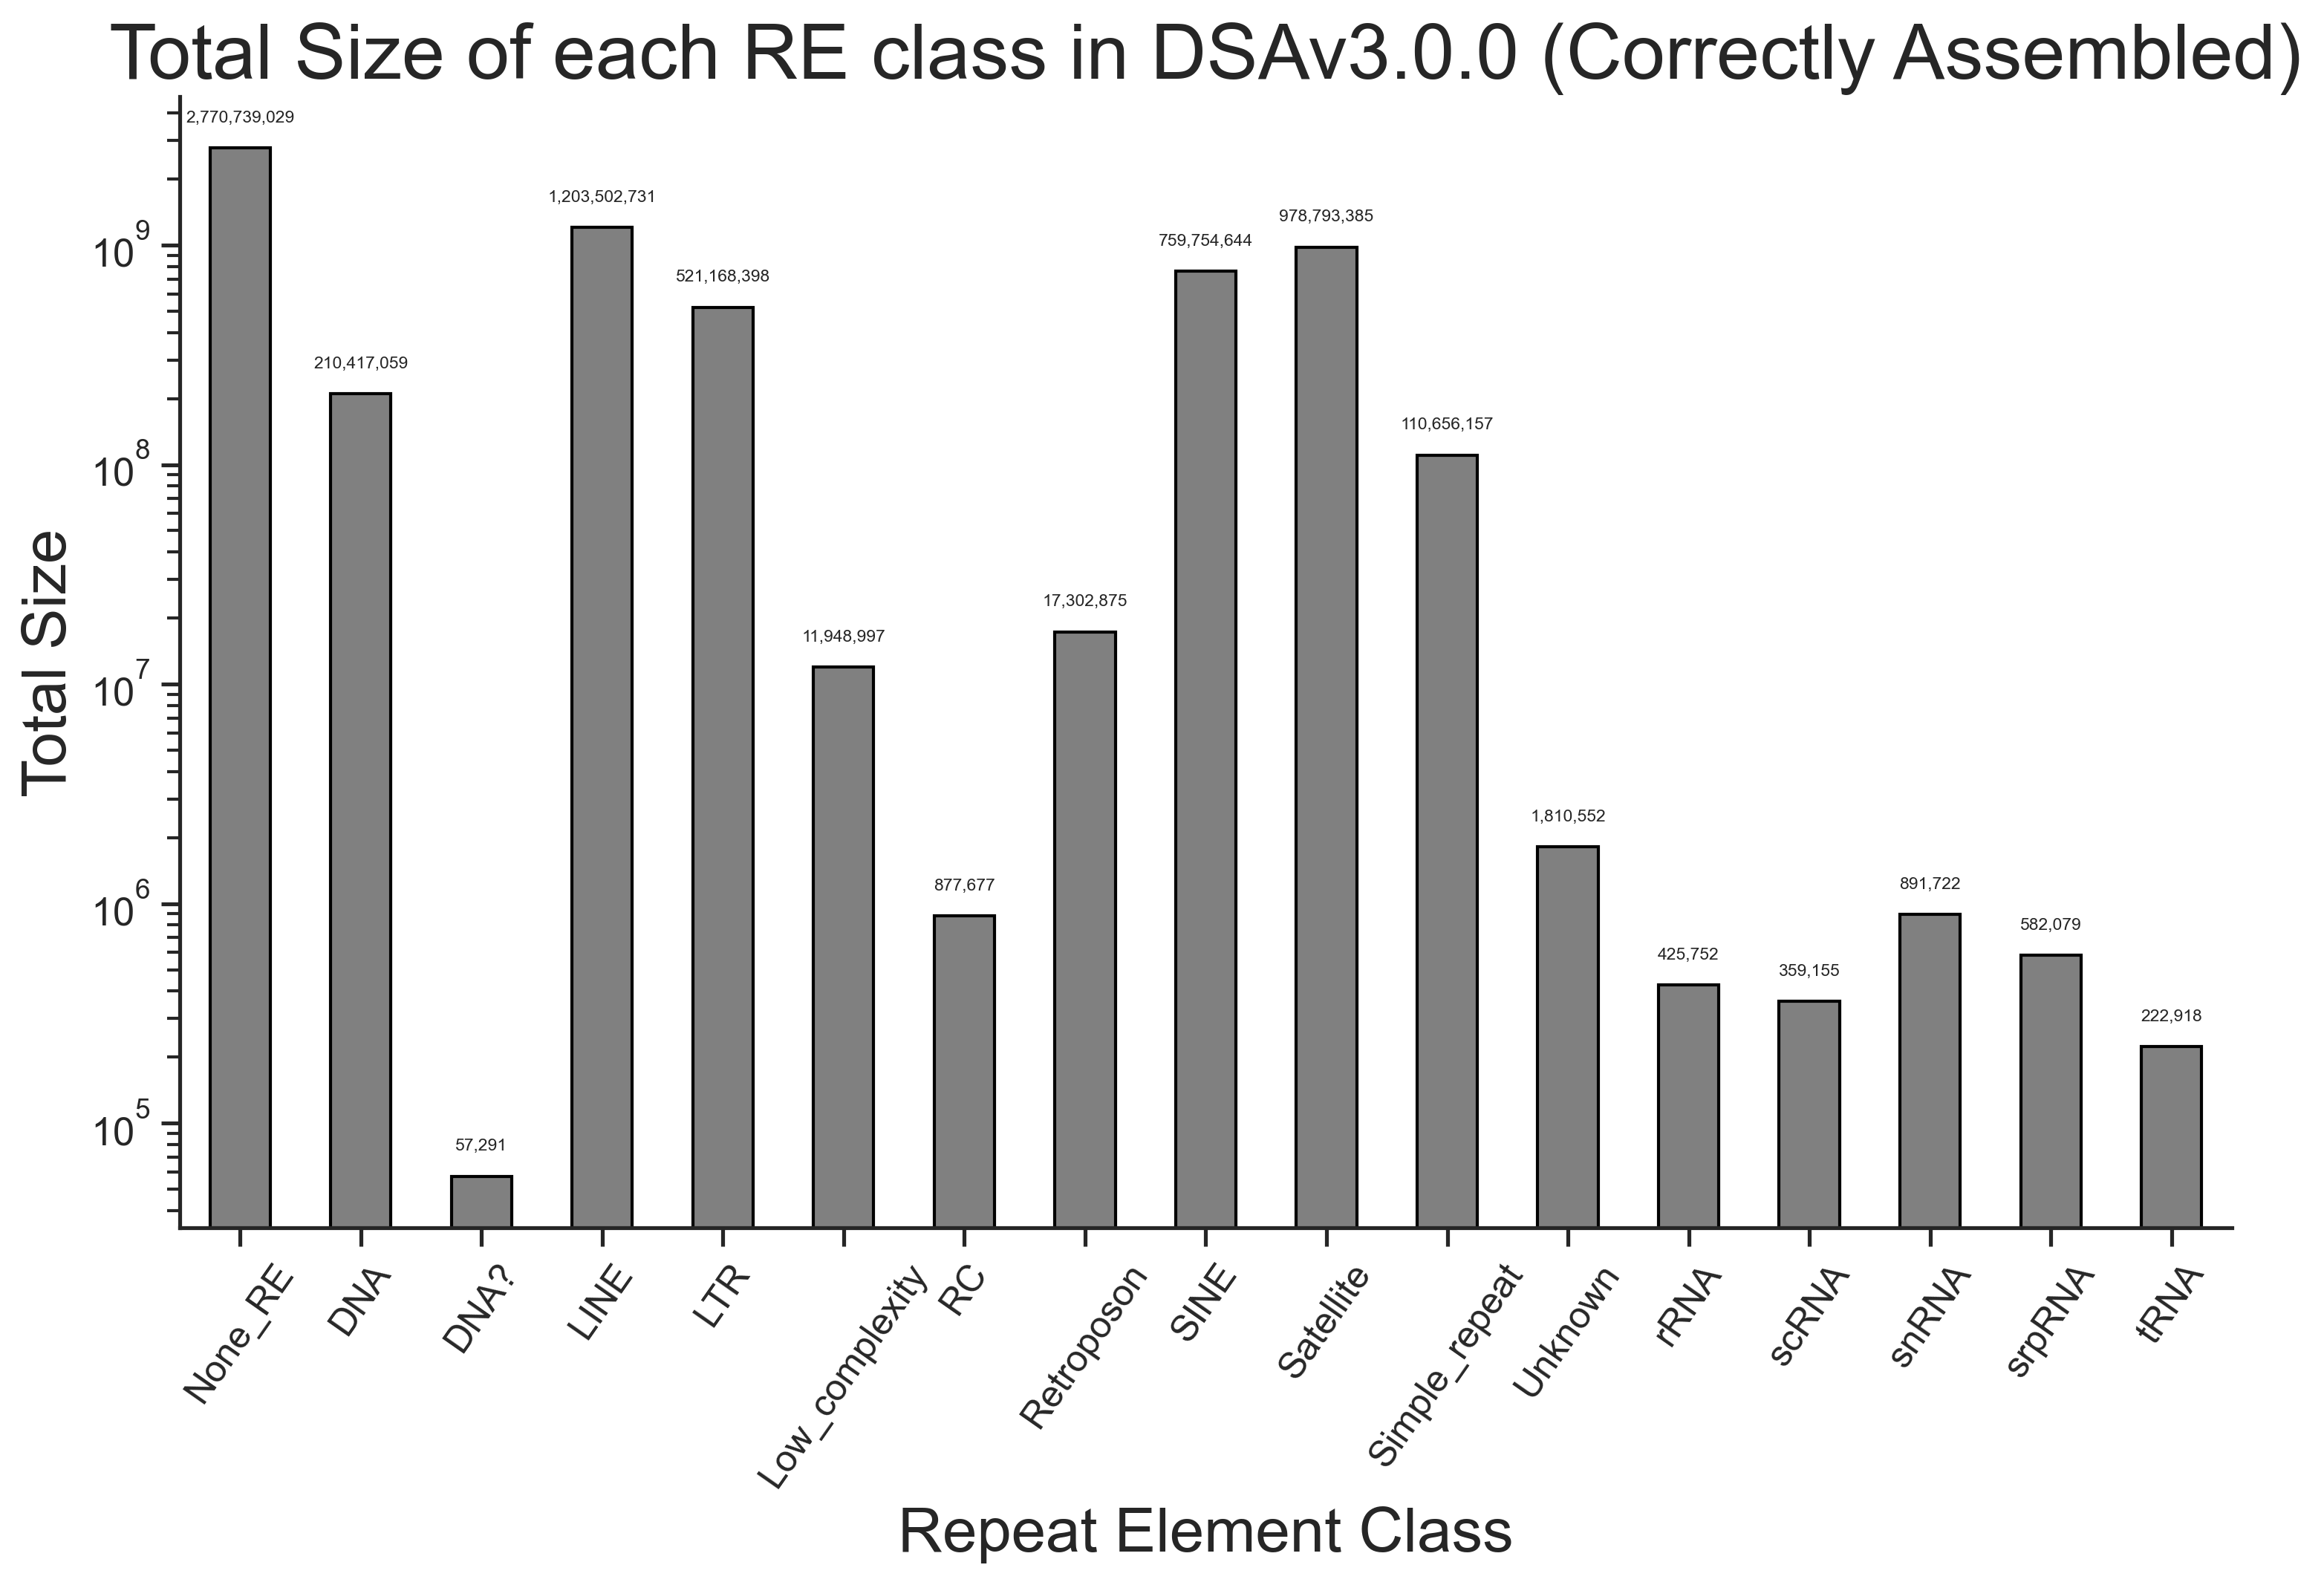

In [4]:
# Size of the None-RE region
#bedtools subtract -a DSA_COLO829BL_v3.0.0_Flagger-NucFlag_removed.bed.gz -b RM.bed.gz | awk 'BEGIN {sum=0} {sum+=$3-$2} END {print sum}'
#2,770,739,029
rec_df = pd.DataFrame(repeatmasker.groupby("repClass")["repsize"].sum())
rec_df.reset_index(inplace=True)
rec_df = pd.concat([pd.DataFrame([['None_RE', 2770739029]], columns=rec_df.columns), rec_df], axis=0).reset_index(drop=True)

rec_df['Exp_Proportion'] = rec_df['repsize'] / rec_df['repsize'].sum()

# %%
fig, ax = plt.subplots(1, 1, figsize=(10, 7), constrained_layout=True)
rec_df.plot(x='repClass', y='repsize', logy=True, kind="bar", color="grey", edgecolor="black", legend=None, ax=ax)
ax.set_title("Total Size of each RE class in DSAv3.0.0 (Correctly Assembled)", fontsize=25)
ax.set_xlabel("Repeat Element Class", fontsize=20)
ax.set_ylabel("Total Size", fontsize=20)
ax.tick_params(axis='x', rotation=55, labelsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=5.5, 
                textcoords='offset points')

plt.savefig(f"{figdir}/RE-COLO829BL-DSA_barchart.pdf")

In [5]:
rec_color_palette = sns.color_palette(palette='terrain', n_colors=rec_df.shape[0])

rec_color_map = {key: color for key, color in zip(rec_df['repClass'].values, rec_color_palette)}

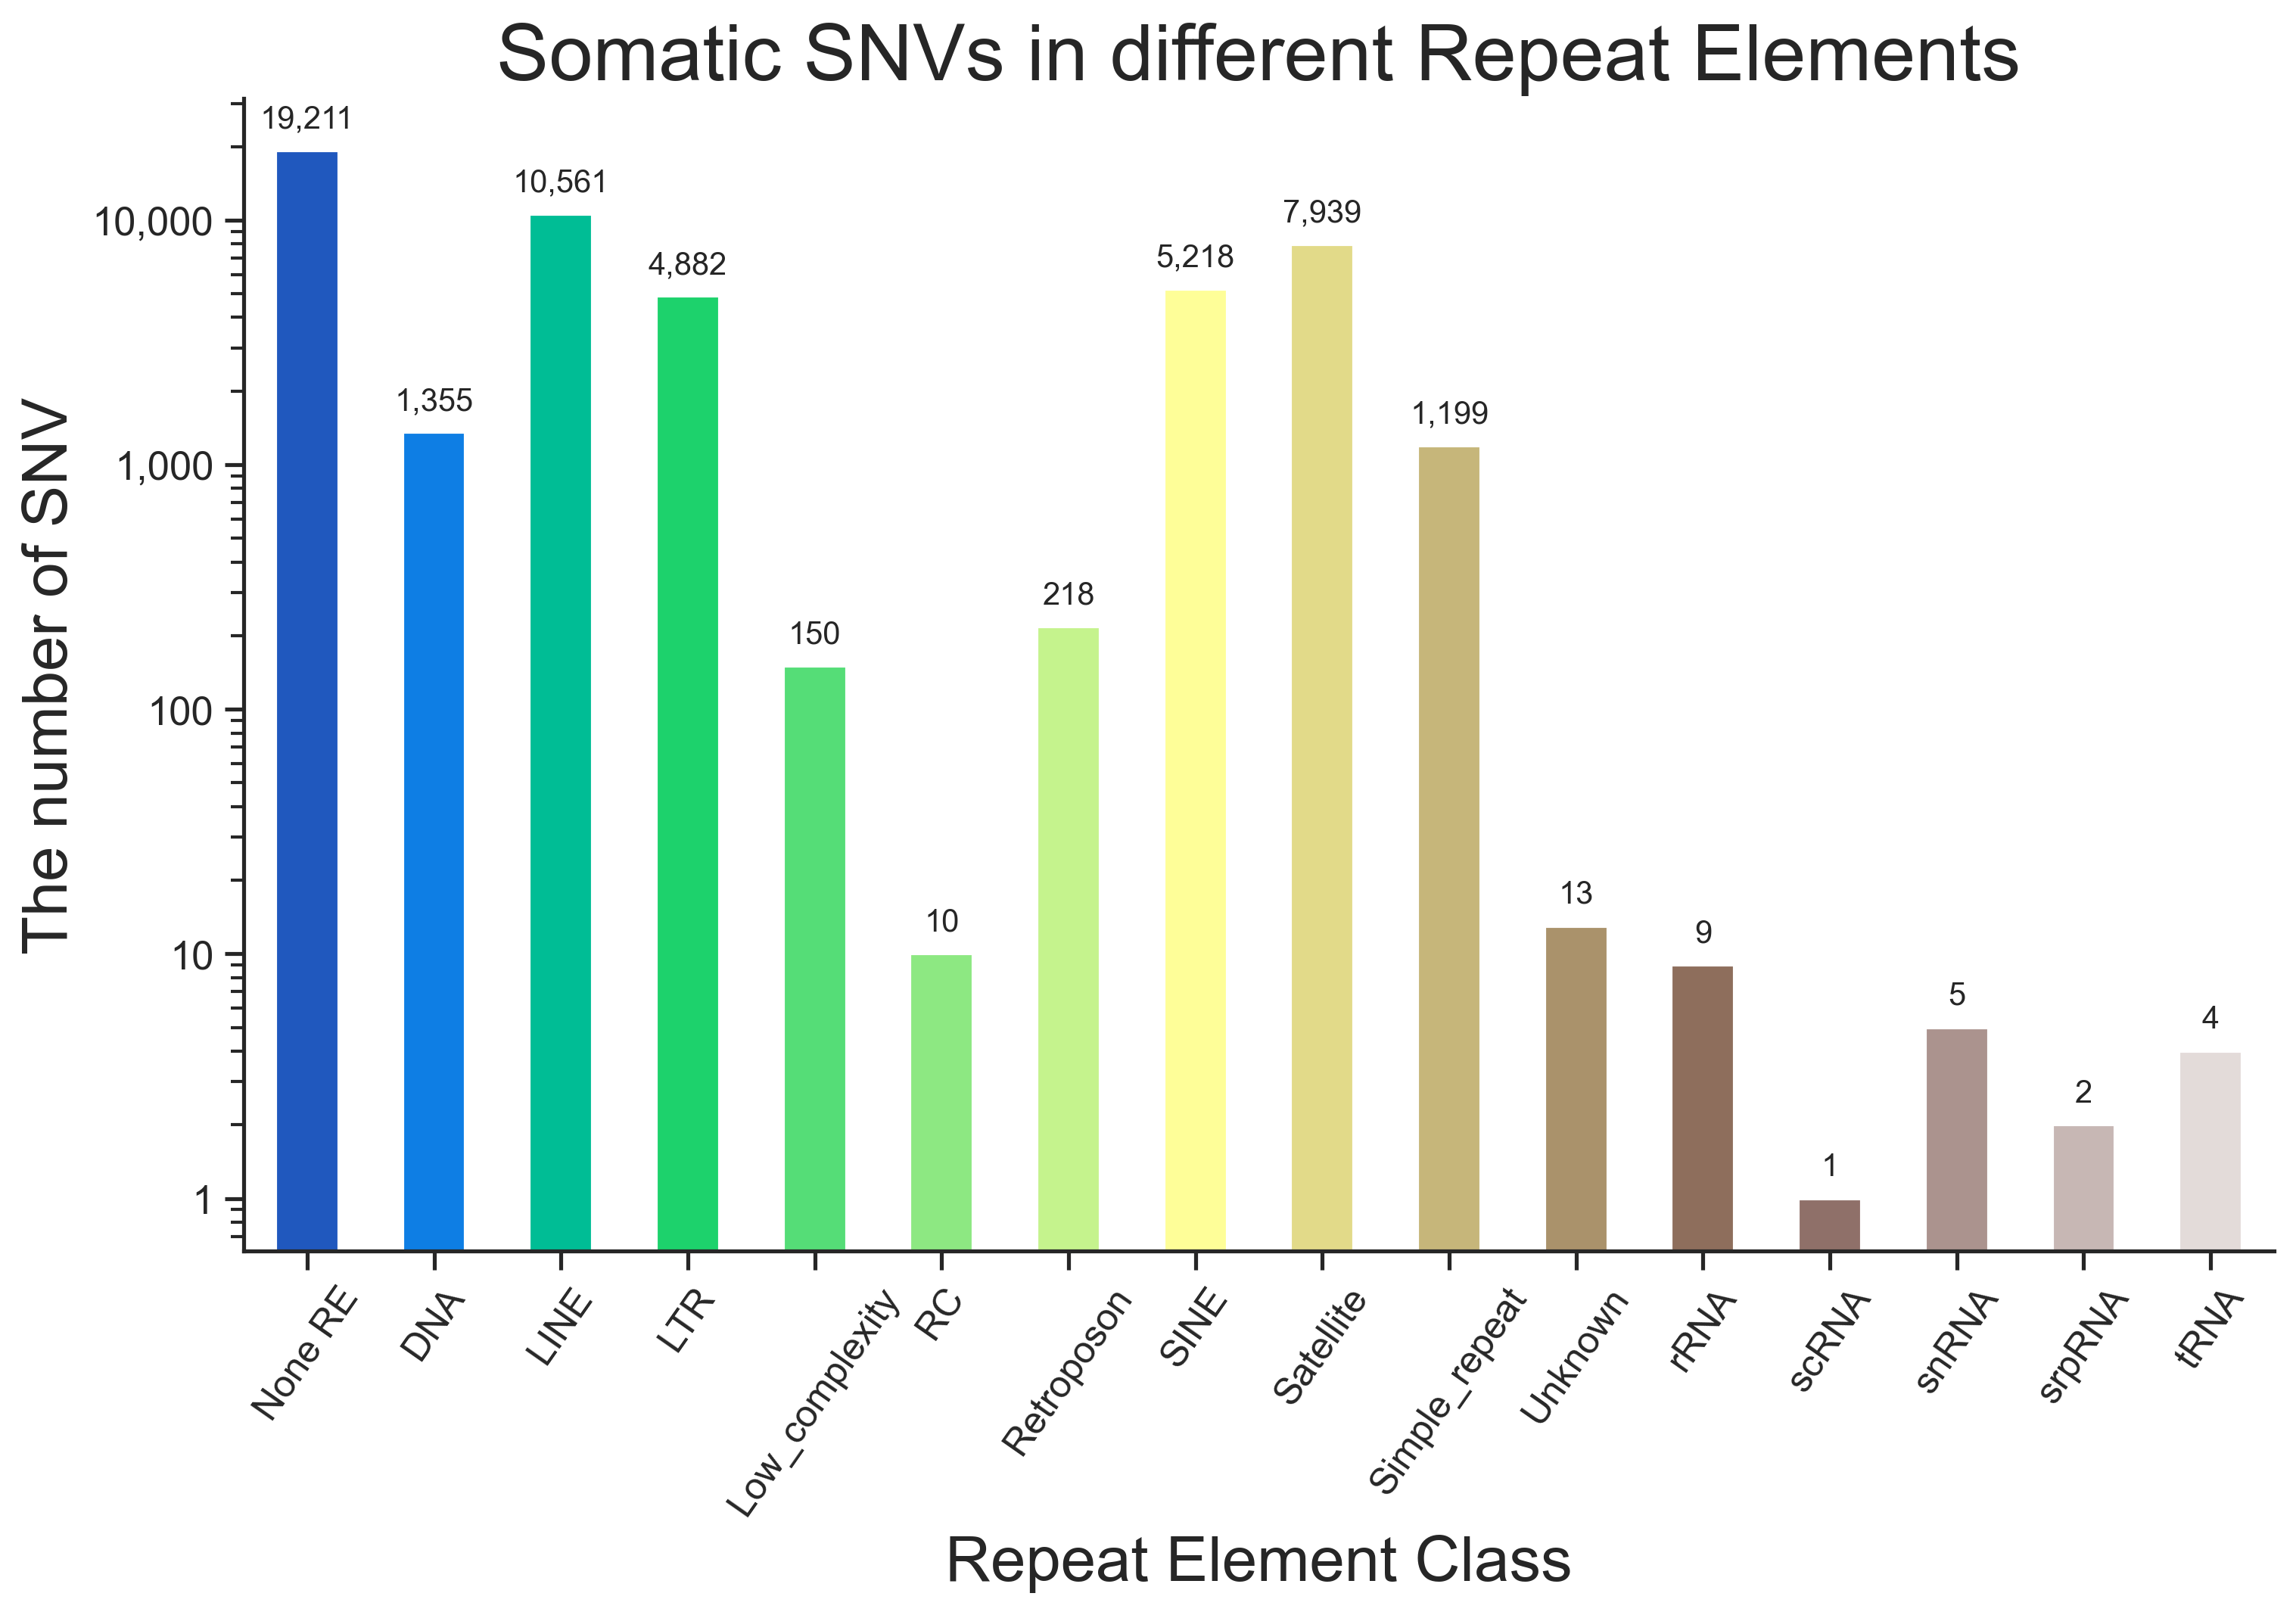

In [6]:
colotb_snvs_shared_final_RM = pd.read_csv("/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/Annotation/SNVs/Rhodonite/Intersect-wao_COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.final.vcf_WITH_RM.tsv", sep="\t", header=None)

# %%
#colotb_snvs_RM[colotb_snvs_RM.iloc[:, 10] != "."]

rec_snv = pd.DataFrame(colotb_snvs_shared_final_RM.groupby(colotb_snvs_shared_final_RM.columns[16]).size(), columns=["SNV_count"])
rec_snv.index.name = "repClass"
rec_snv.reset_index(inplace=True)
rec_snv.at[0, 'repClass'] = 'None_RE'
rec_snv['Obs_Proportion'] = rec_snv['SNV_count'] / rec_snv['SNV_count'].sum()

fig, ax = plt.subplots(1,1, figsize=(10, 7), constrained_layout=True)
rec_snv.plot(kind="bar", x="repClass", y="SNV_count", logy=True, color=[rec_color_map[i] for i in rec_snv['repClass'].values], legend=None, ax=ax)
ax.set_title("Somatic SNVs in different Repeat Elements", fontsize=25)
ax.set_xlabel("Repeat Element Class", fontsize=20)
ax.set_ylabel("The number of SNV", fontsize=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
new_labels = [i.get_text() for i in ax.get_xticklabels()]
new_labels[0] = 'None RE'
ax.set_xticklabels(new_labels)
ax.tick_params(axis='x', rotation=55, labelsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=10, 
                textcoords='offset points')



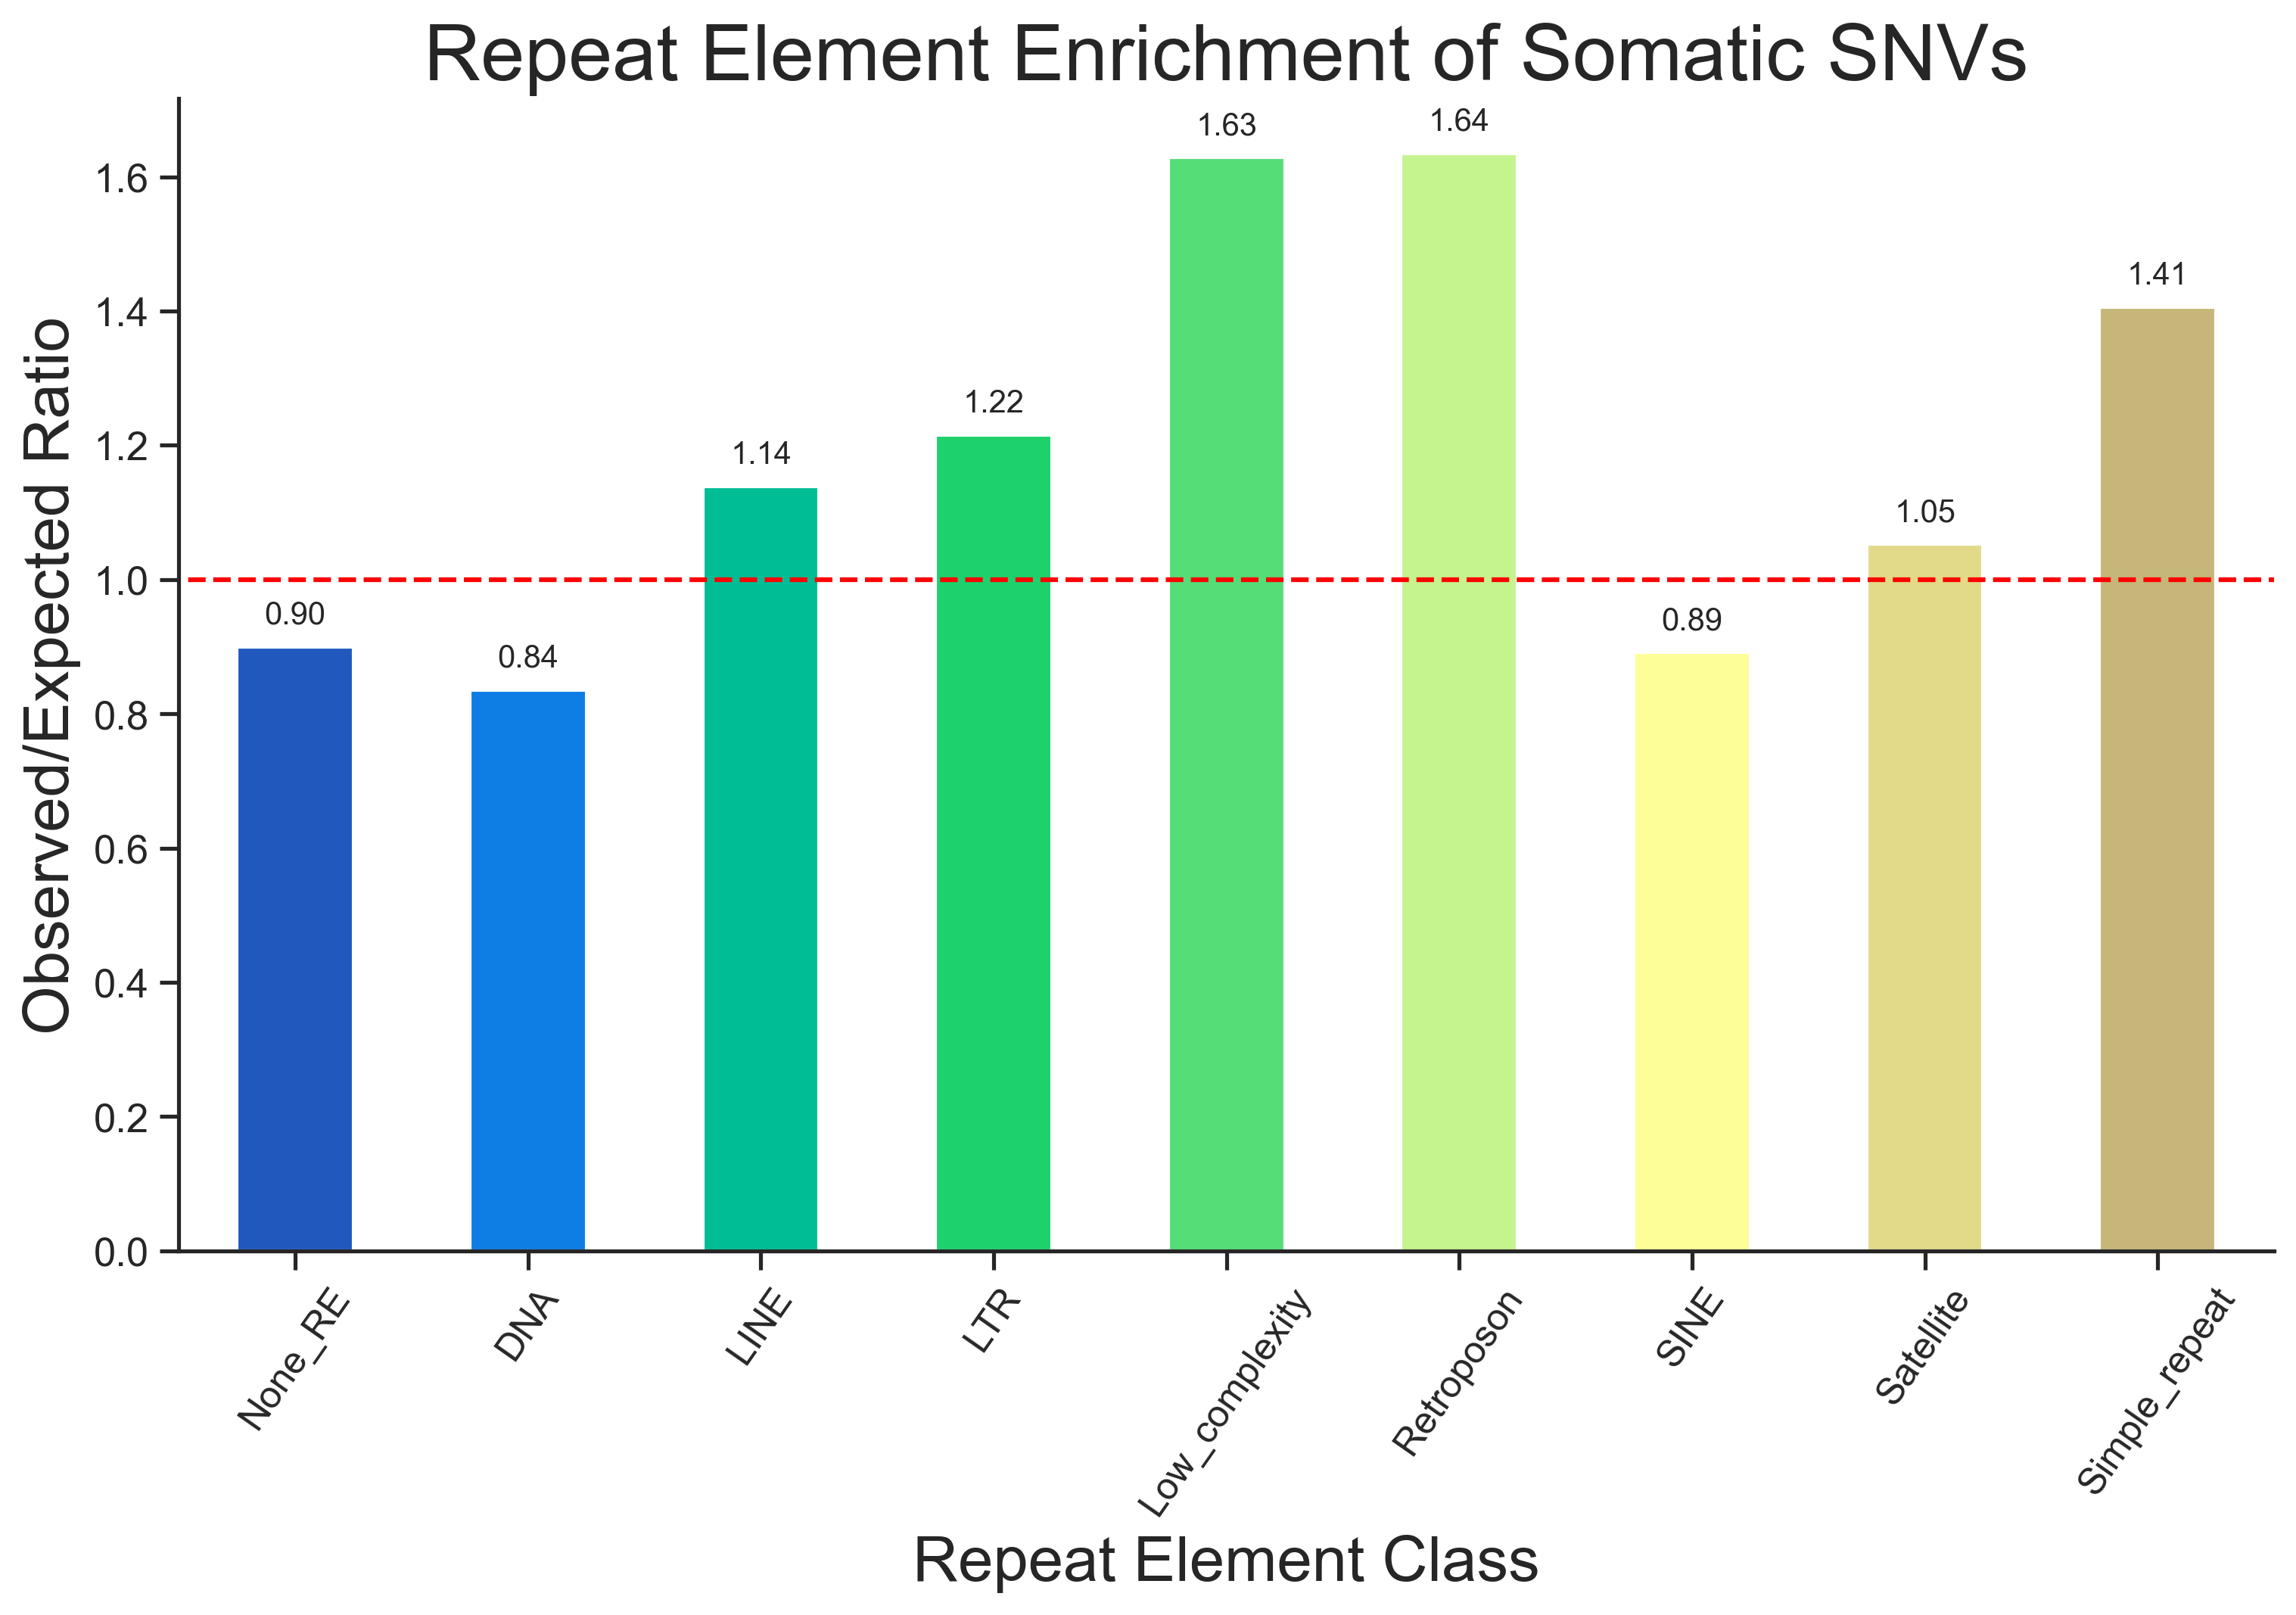

In [7]:
# %%
rec_snv_obs_exp = pd.merge(rec_df, rec_snv, on="repClass", how="inner")
rec_snv_obs_exp = rec_snv_obs_exp[rec_snv_obs_exp['SNV_count'] > 20]
rec_snv_obs_exp['Obs-Exp_Ratio'] = rec_snv_obs_exp['Obs_Proportion'] / rec_snv_obs_exp['Exp_Proportion']

fig, ax = plt.subplots(1, 1, figsize=(10, 7), constrained_layout=True)
rec_snv_obs_exp.plot(kind="bar", x='repClass', y='Obs-Exp_Ratio', legend=None, color=[rec_color_map[i] for i in rec_snv_obs_exp['repClass'].values], ax=ax)
ax.tick_params(axis='x', rotation=55, labelsize=12)
ax.set_title("Repeat Element Enrichment of Somatic SNVs", fontsize=25)
ax.set_xlabel("Repeat Element Class", fontsize=20)
ax.set_ylabel("Observed/Expected Ratio", fontsize=20)
ax.hlines(y=1, xmin=-1, xmax=rec_snv_obs_exp.shape[0], color='red', linestyle='--')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=10, 
                textcoords='offset points')

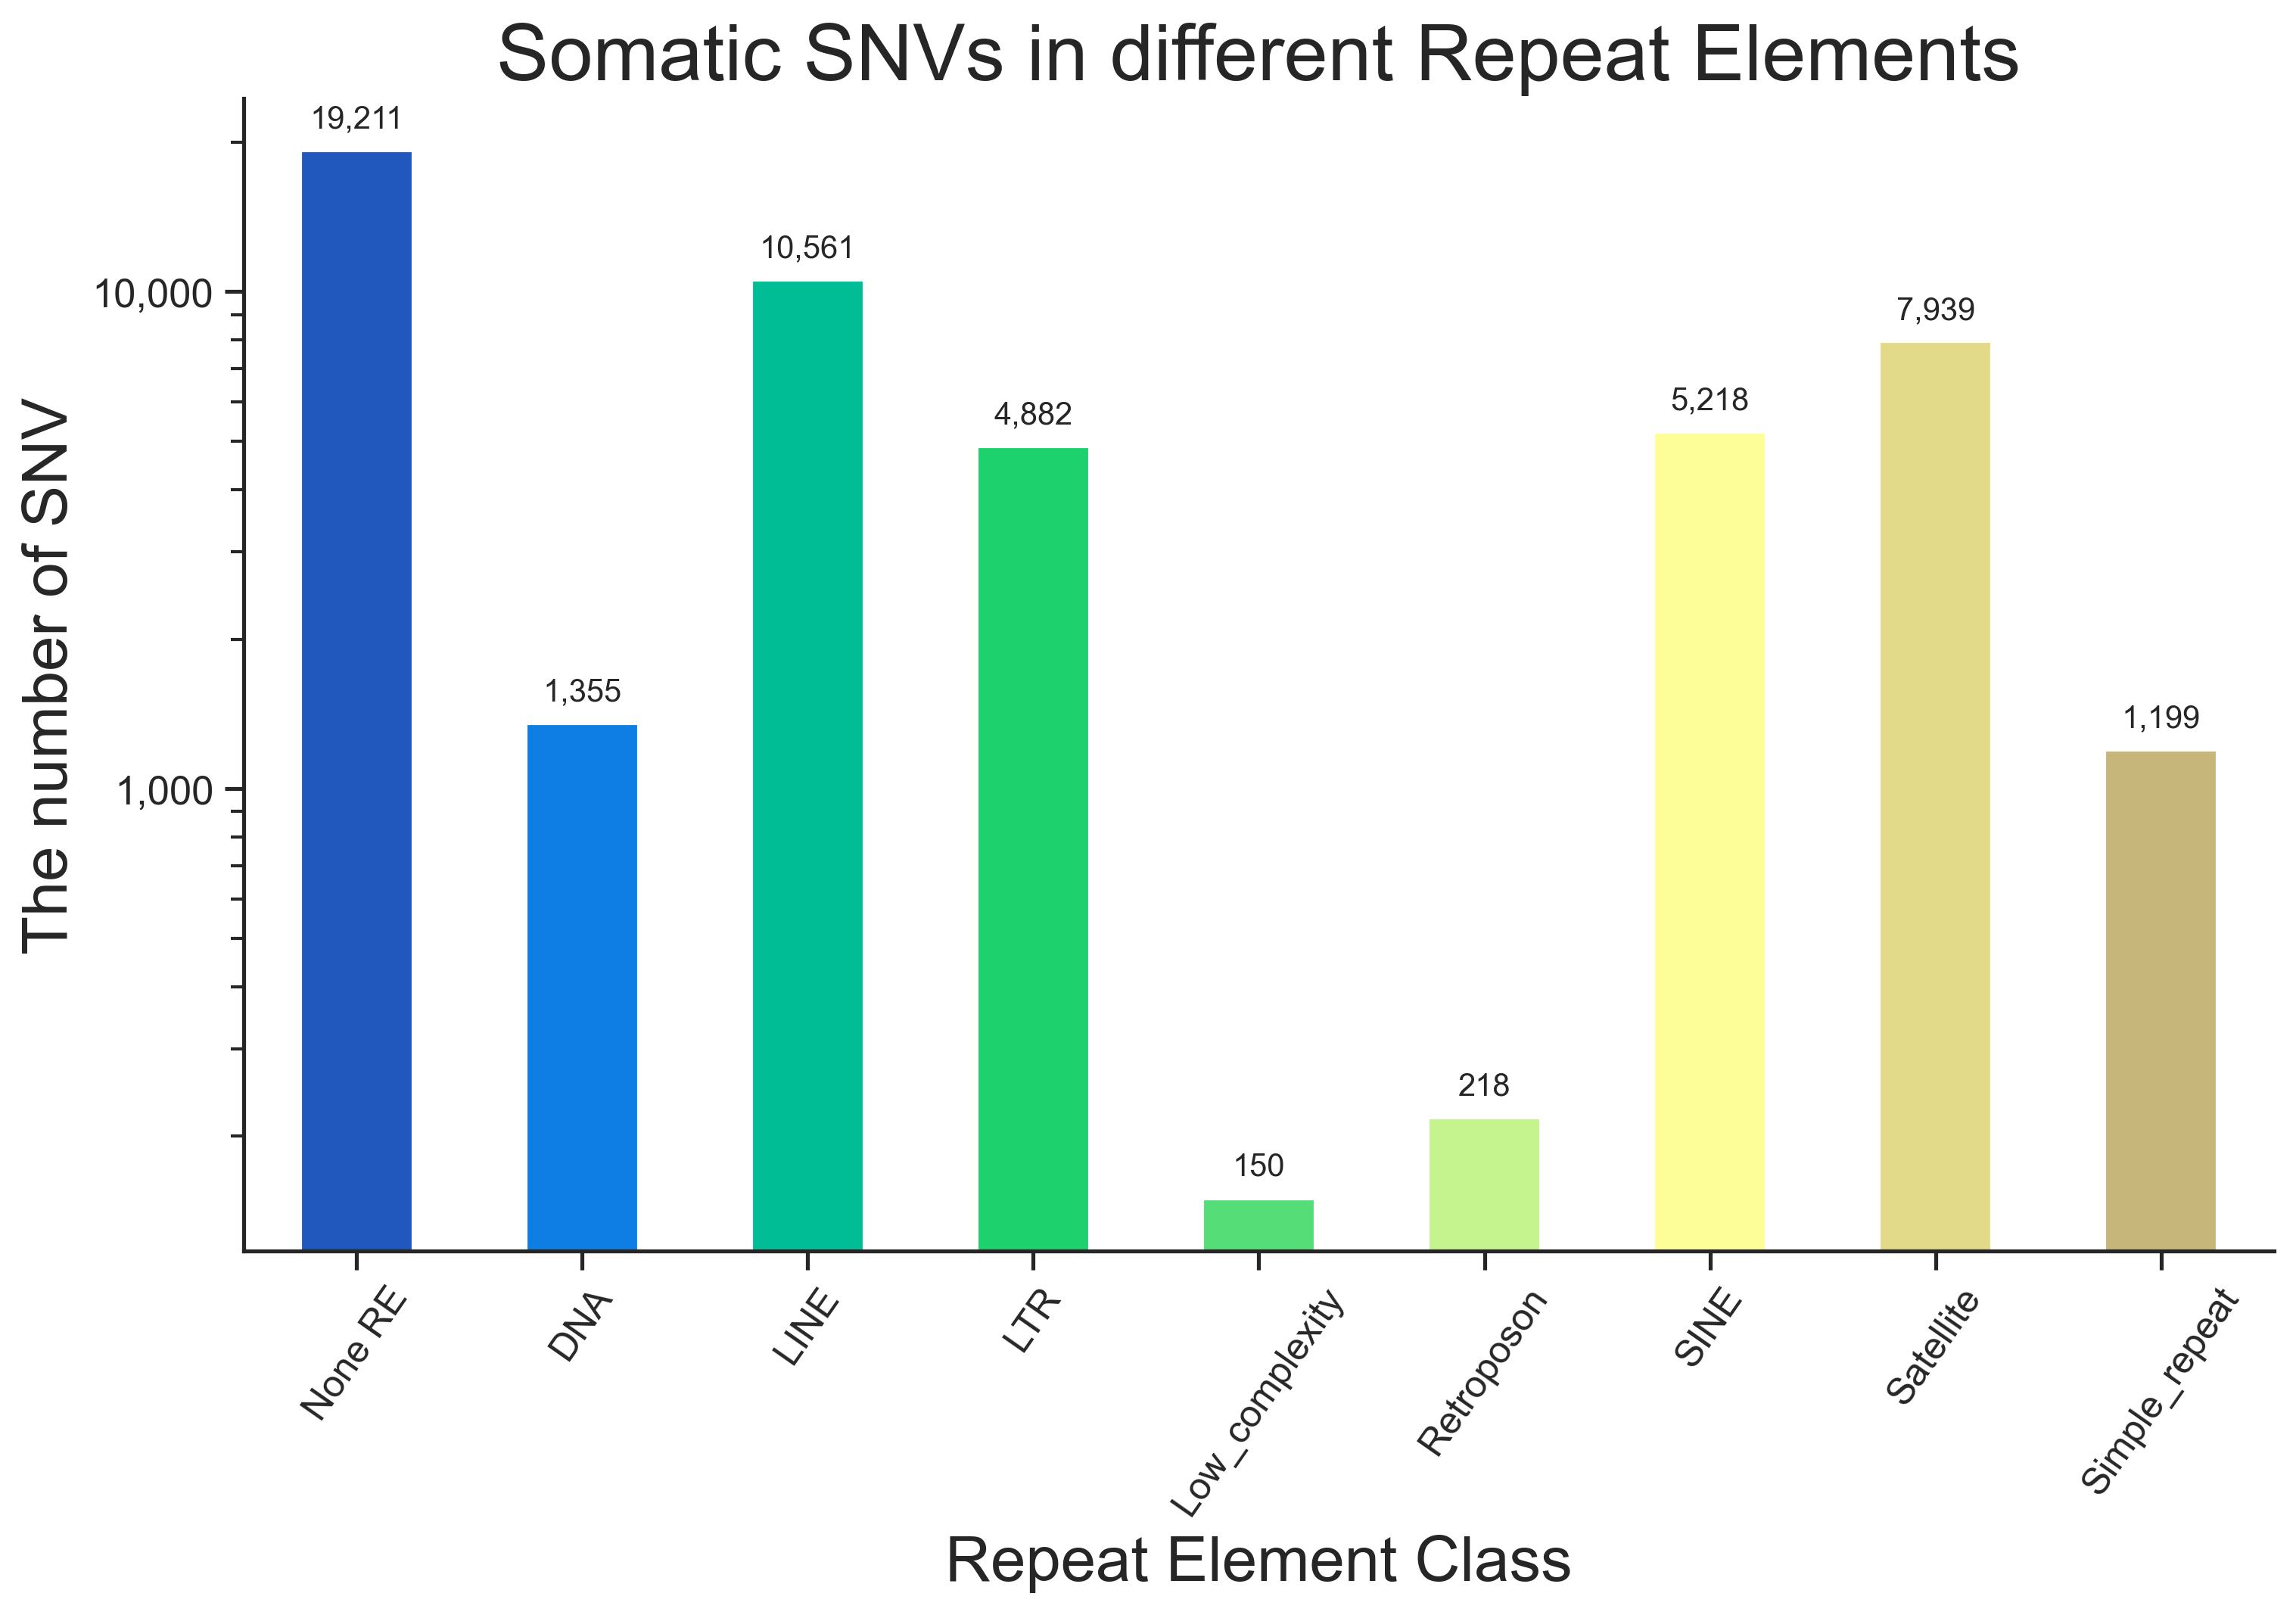

In [8]:
rec_snv_trimmed = rec_snv[rec_snv['repClass'].isin(rec_snv_obs_exp['repClass'].values)].copy()

fig, ax = plt.subplots(1,1, figsize=(10, 7), constrained_layout=True)
rec_snv_trimmed.plot(kind="bar", x="repClass", y="SNV_count", logy=True, color=[rec_color_map[i] for i in rec_snv_trimmed['repClass'].values], legend=None, ax=ax)
ax.set_title("Somatic SNVs in different Repeat Elements", fontsize=25)
ax.set_xlabel("Repeat Element Class", fontsize=20)
ax.set_ylabel("The number of SNV", fontsize=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
new_labels = [i.get_text() for i in ax.get_xticklabels()]
new_labels[0] = 'None RE'
ax.set_xticklabels(new_labels)
ax.tick_params(axis='x', rotation=55, labelsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=10, 
                textcoords='offset points')

## Somatic SNVs not liftOver to hg38

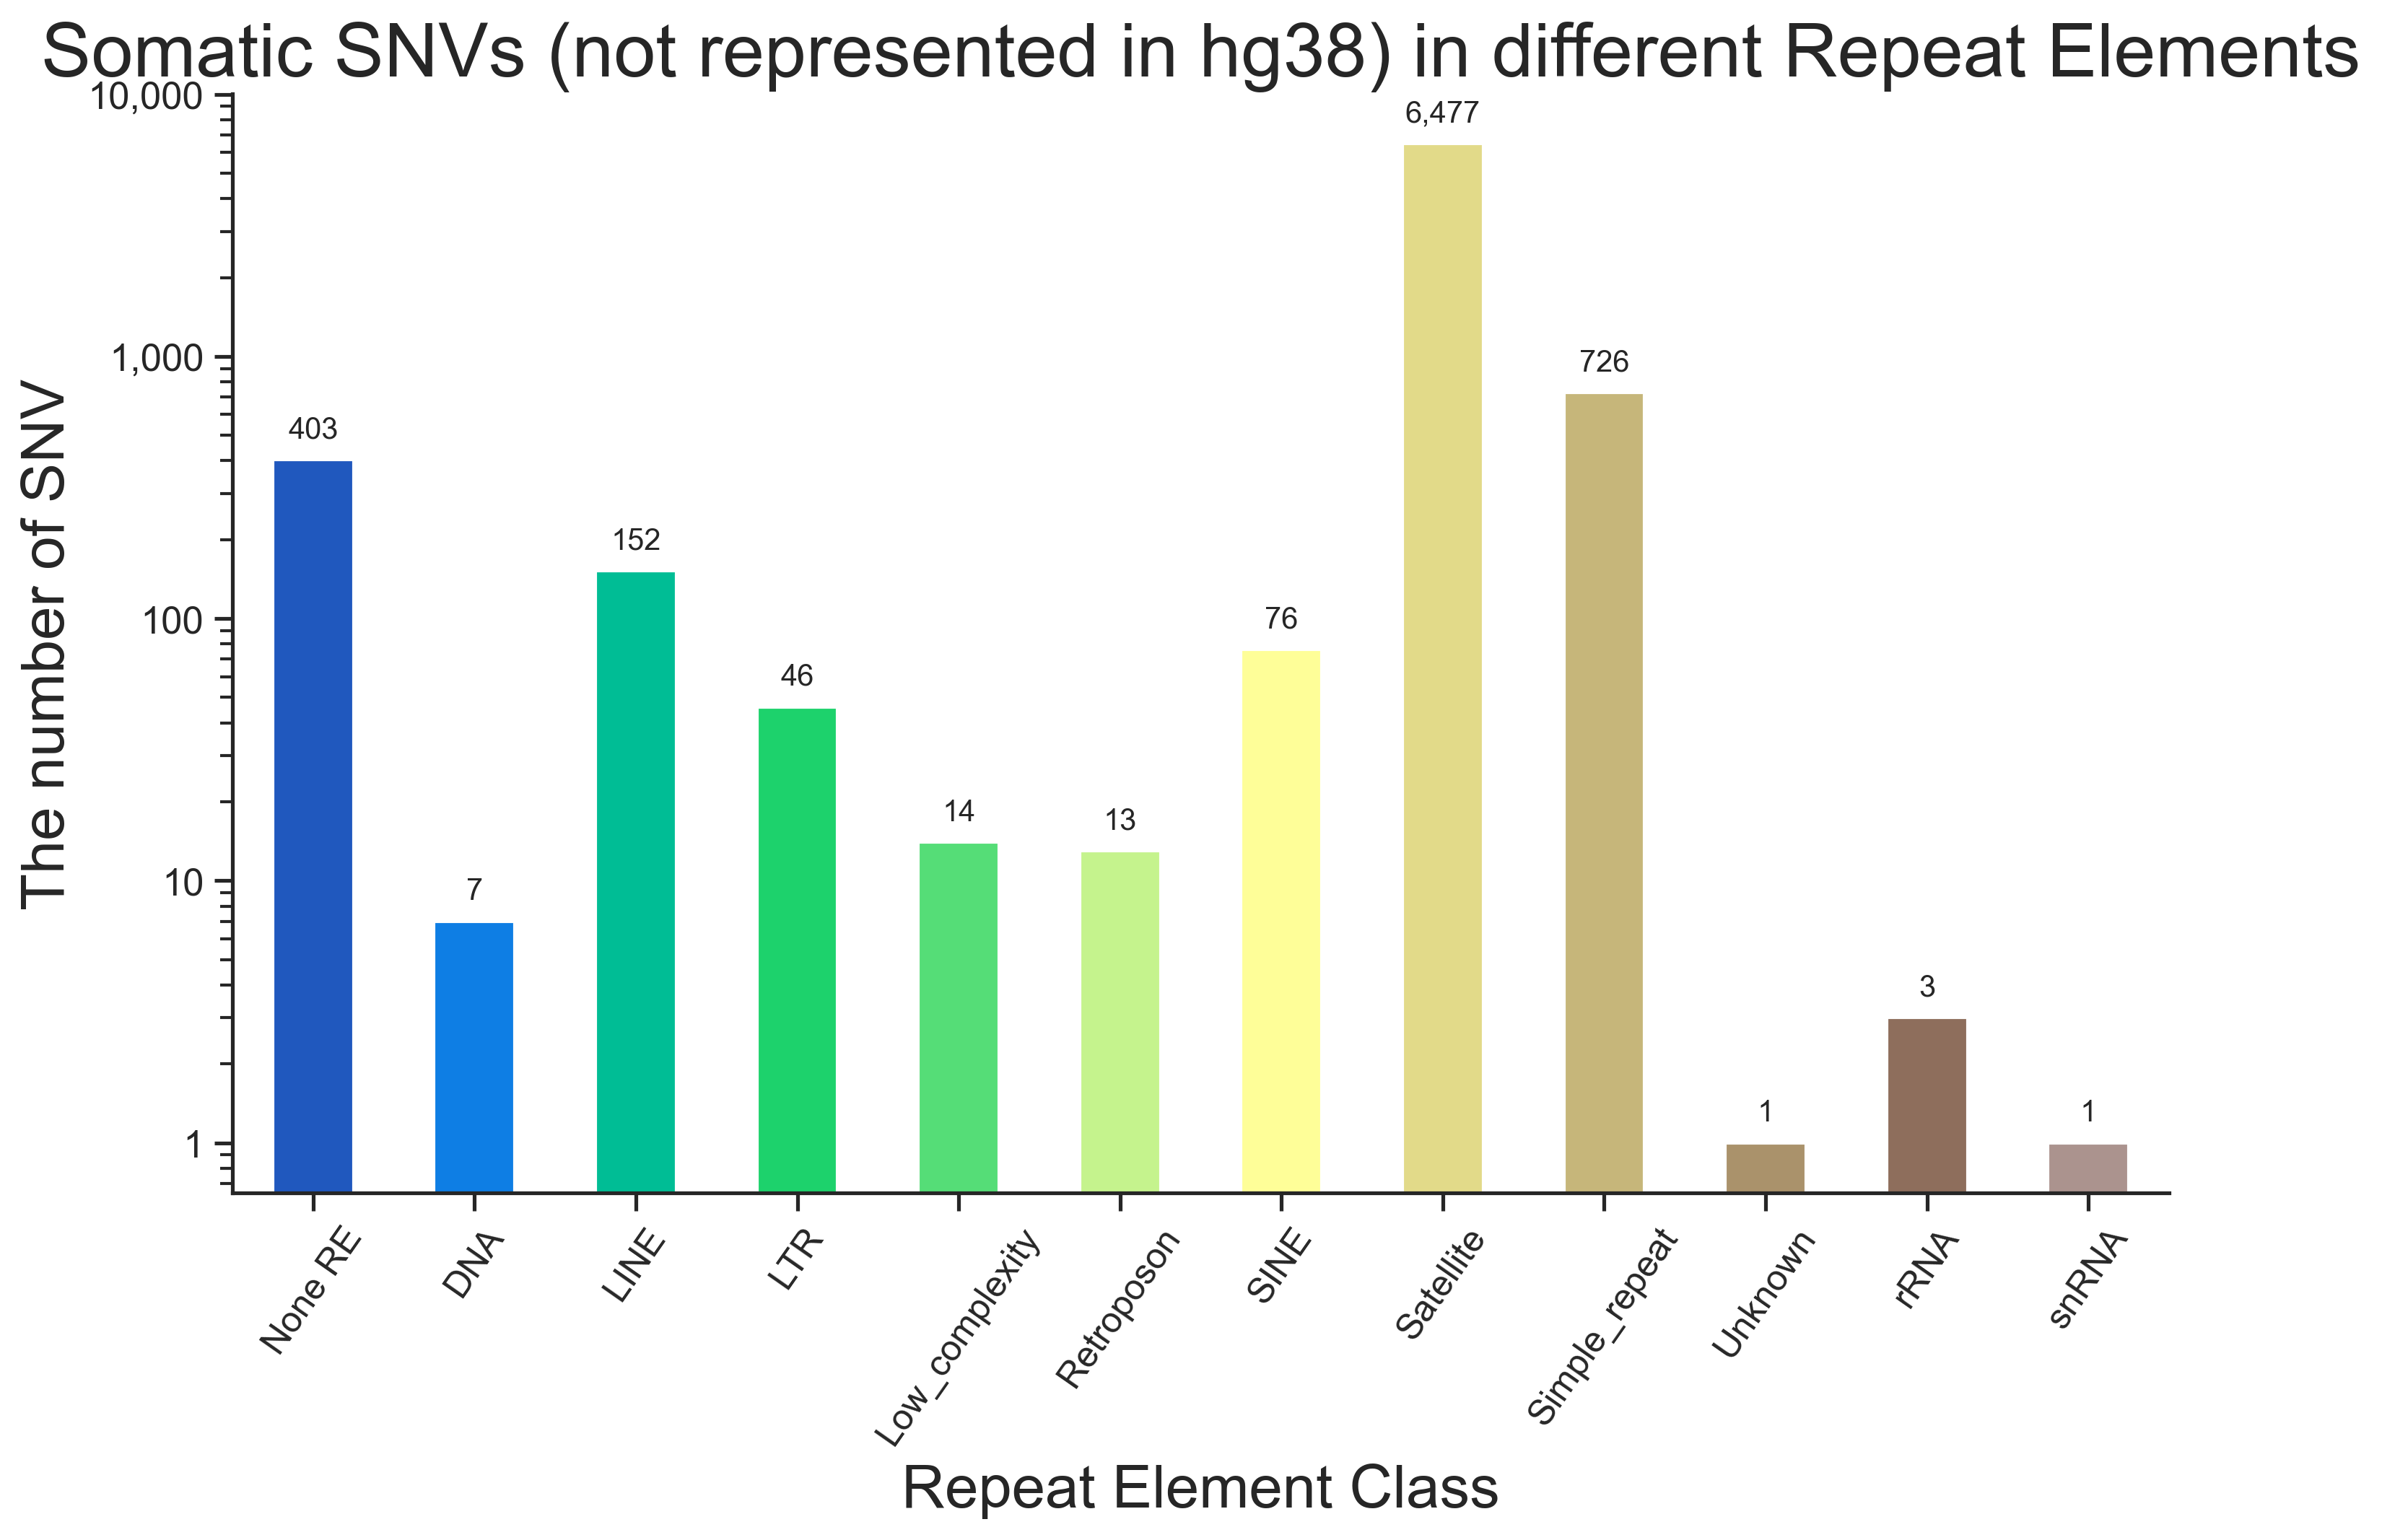

In [13]:
colotb_snvs_shared_final_liftoverREJECT_RM = pd.read_csv("/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/Annotation/SNVs/Rhodonite/Intersect-wao_REJECT_COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.final.tohg38.split.vcf_WITH_RM.tsv", sep="\t", header=None)

rec_liftoverreject_snv = pd.DataFrame(colotb_snvs_shared_final_liftoverREJECT_RM.groupby(colotb_snvs_shared_final_liftoverREJECT_RM.columns[16]).size(), columns=["SNV_count"])
rec_liftoverreject_snv.index.name = "repClass"
rec_liftoverreject_snv.reset_index(inplace=True)
rec_liftoverreject_snv.at[0, 'repClass'] = 'None_RE'
rec_liftoverreject_snv['Obs_Proportion'] = rec_liftoverreject_snv['SNV_count'] / rec_liftoverreject_snv['SNV_count'].sum()

fig, ax = plt.subplots(1,1, figsize=(10, 7), constrained_layout=True)
rec_liftoverreject_snv.plot(kind="bar", x="repClass", y="SNV_count", logy=True, color=[rec_color_map[i] for i in rec_liftoverreject_snv['repClass'].values], legend=None, ax=ax)
ax.set_title("Somatic SNVs (not represented in hg38) in different Repeat Elements", fontsize=25)
ax.set_xlabel("Repeat Element Class", fontsize=20)
ax.set_ylabel("The number of SNV", fontsize=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
new_labels = [i.get_text() for i in ax.get_xticklabels()]
new_labels[0] = 'None RE'
ax.set_xticklabels(new_labels)
ax.tick_params(axis='x', rotation=55, labelsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=10, 
                textcoords='offset points')



In [14]:
rec_liftoverreject_snv

repClass  SNV_count  Obs_Proportion
0          None_RE        403        0.050890
1              DNA          7        0.000884
2             LINE        152        0.019194
3              LTR         46        0.005809
4   Low_complexity         14        0.001768
5       Retroposon         13        0.001642
6             SINE         76        0.009597
7        Satellite       6477        0.817906
8    Simple_repeat        726        0.091678
9          Unknown          1        0.000126
10            rRNA          3        0.000379
11           snRNA          1        0.000126

In [19]:
rec_snv_trimmed_merged_rec_liftoverreject_snv = pd.merge(rec_snv_trimmed, rec_liftoverreject_snv, on="repClass", how="inner", suffixes=('_total', '_nonliftover'))
rec_snv_trimmed_merged_rec_liftoverreject_snv

repClass  SNV_count_total  Obs_Proportion_total  \
0         None_RE            19211              0.378341   
1             DNA             1355              0.026685   
2            LINE            10561              0.207988   
3             LTR             4882              0.096146   
4  Low_complexity              150              0.002954   
5      Retroposon              218              0.004293   
6            SINE             5218              0.102763   
7       Satellite             7939              0.156350   
8   Simple_repeat             1199              0.023613   

   SNV_count_nonliftover  Obs_Proportion_nonliftover  
0                    403                    0.050890  
1                      7                    0.000884  
2                    152                    0.019194  
3                     46                    0.005809  
4                     14                    0.001768  
5                     13                    0.001642  
6                     76                    0.009597  
7                   6477                    0.817906  
8                    726                    0.091678

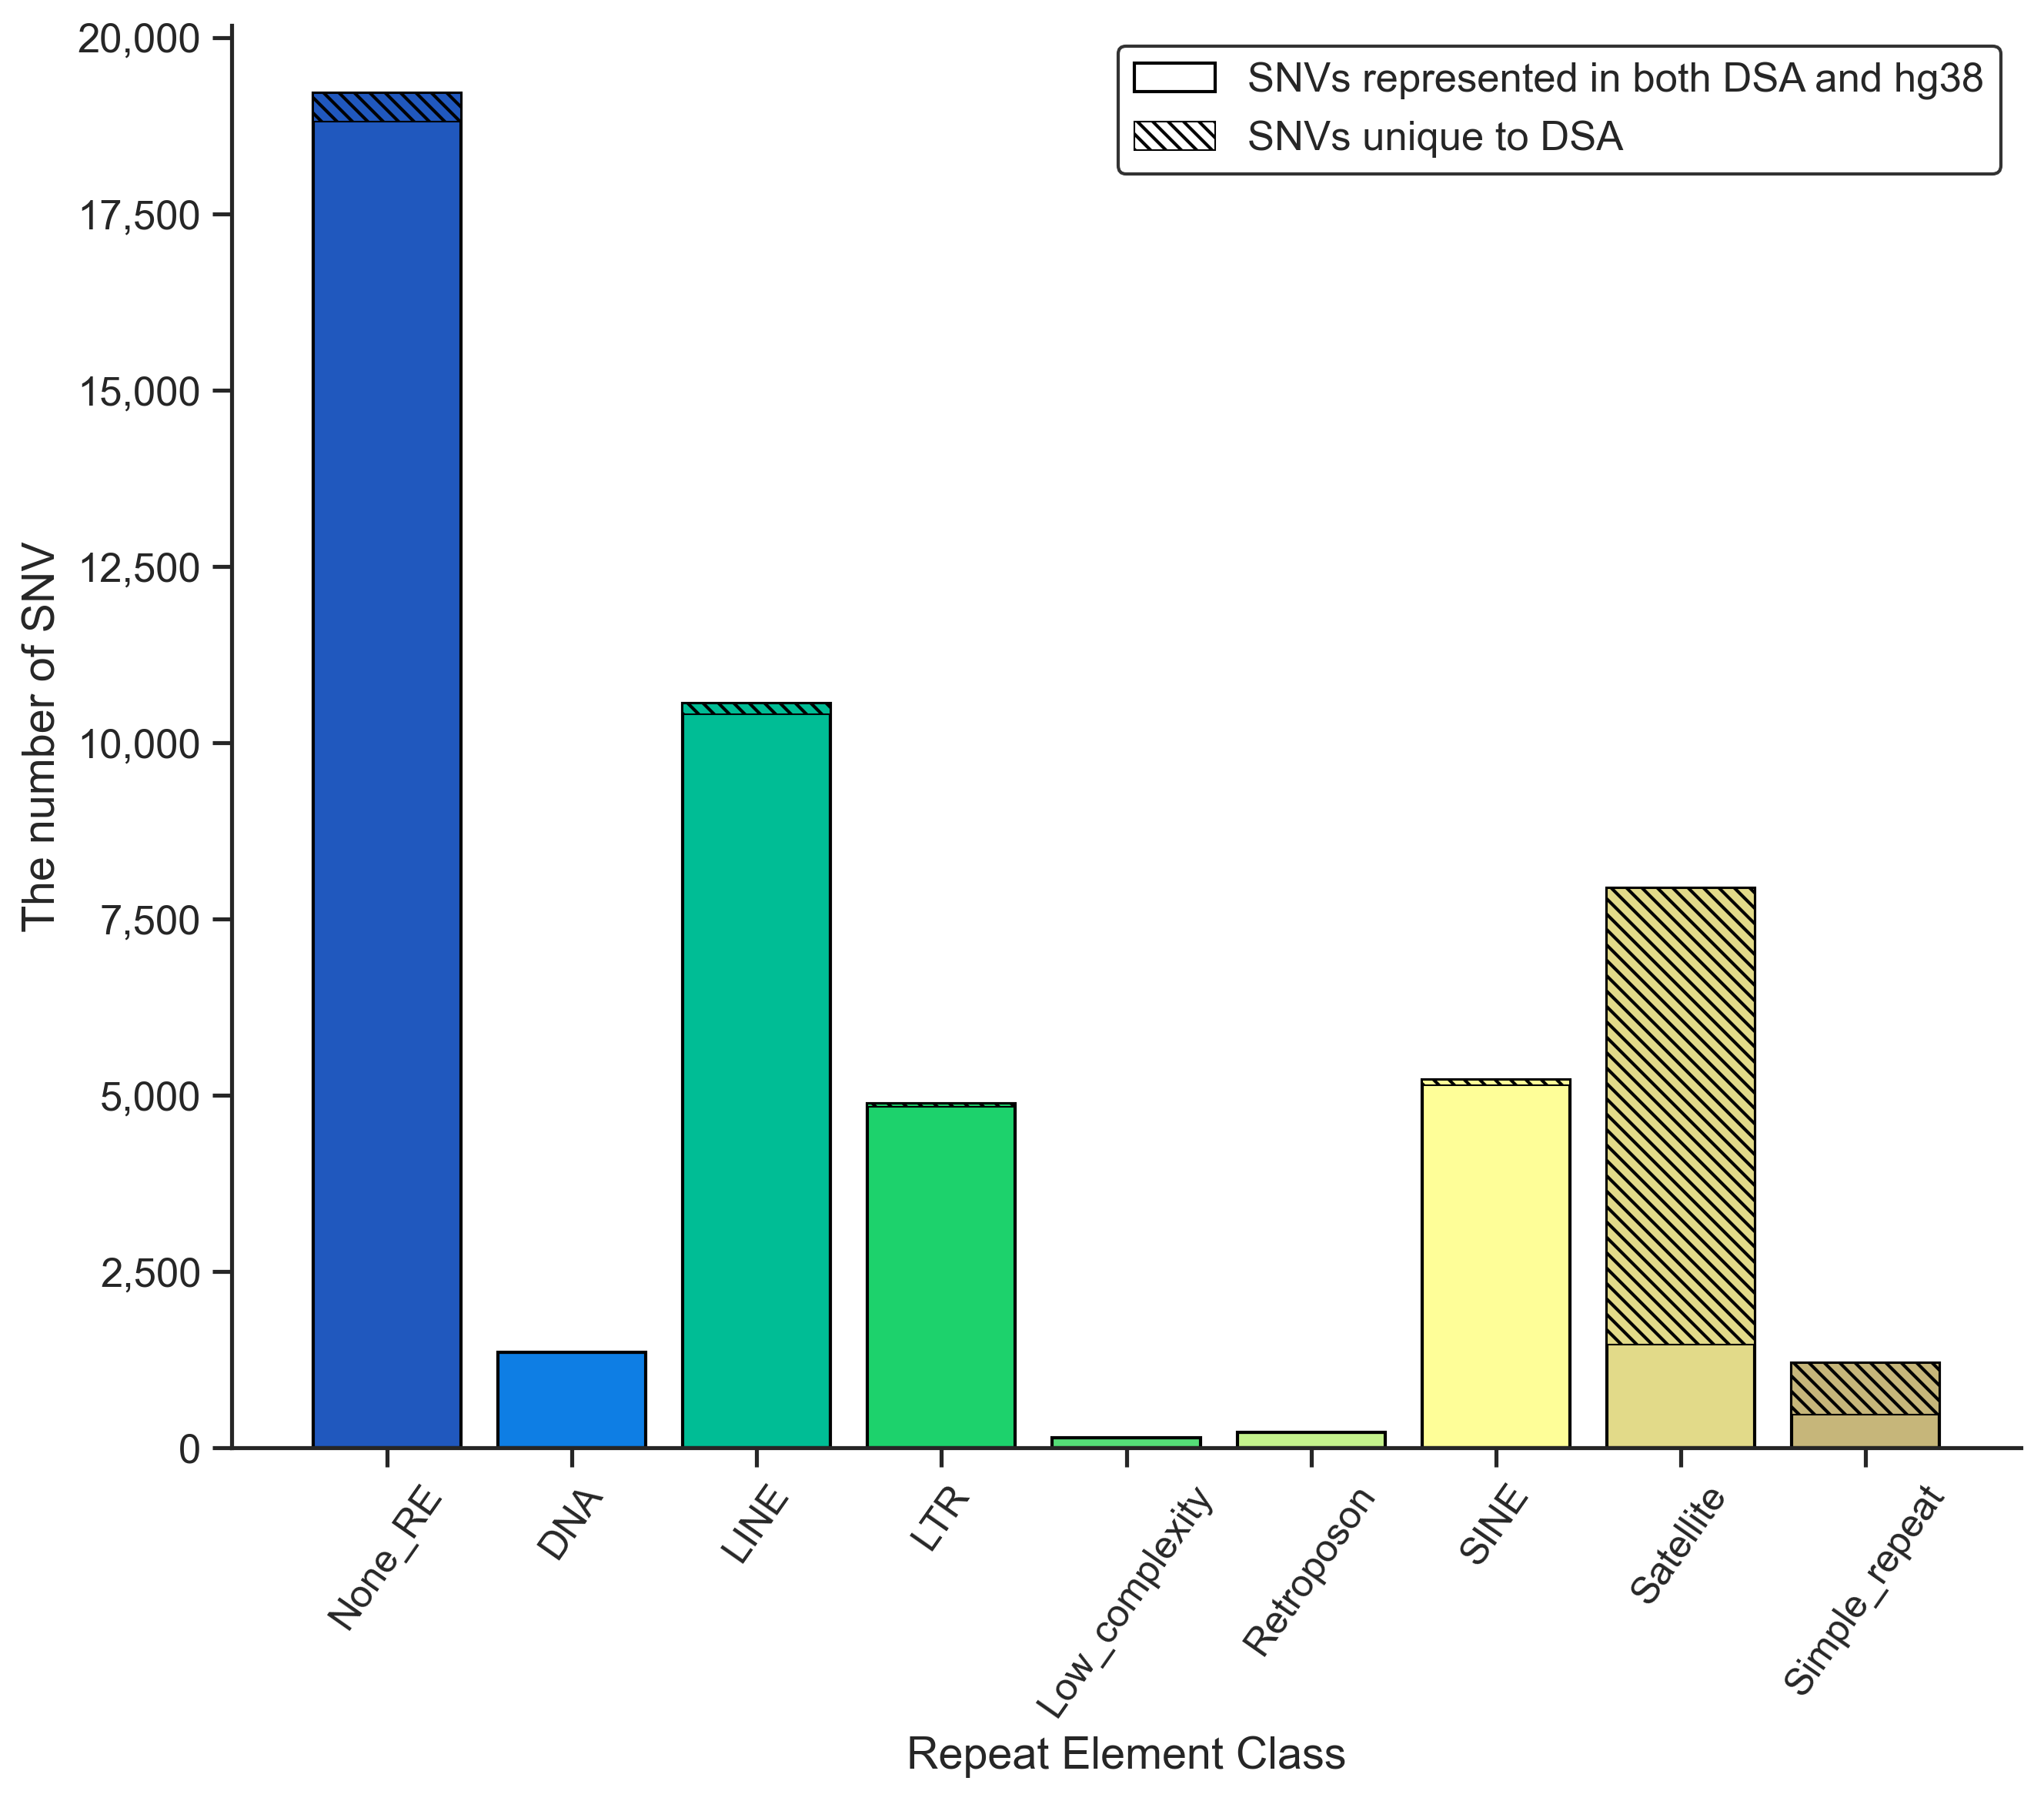

In [70]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'], rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_total'], label='SNVs represented in both DSA and hg38', edgecolor='black', color=[rec_color_map[i] for i in rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'].values])
ax.bar(rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'], rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_nonliftover'], bottom=rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_total'] - rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_nonliftover'], label='SNVs unique to DSA', edgecolor='black', linewidth=0.5, hatch='\\\\\\\\\\', color=[rec_color_map[i] for i in rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'].values])

#ax.set_yscale('log')
ax.set_xlabel('Repeat Element Class')
ax.set_ylabel('The number of SNV')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.tick_params(axis='x', rotation=55, labelsize=12)

legend = ax.legend()
legend.get_frame().set_edgecolor('black')
legend.legend_handles[0].set_facecolor('white')
legend.legend_handles[1].set_facecolor('white')

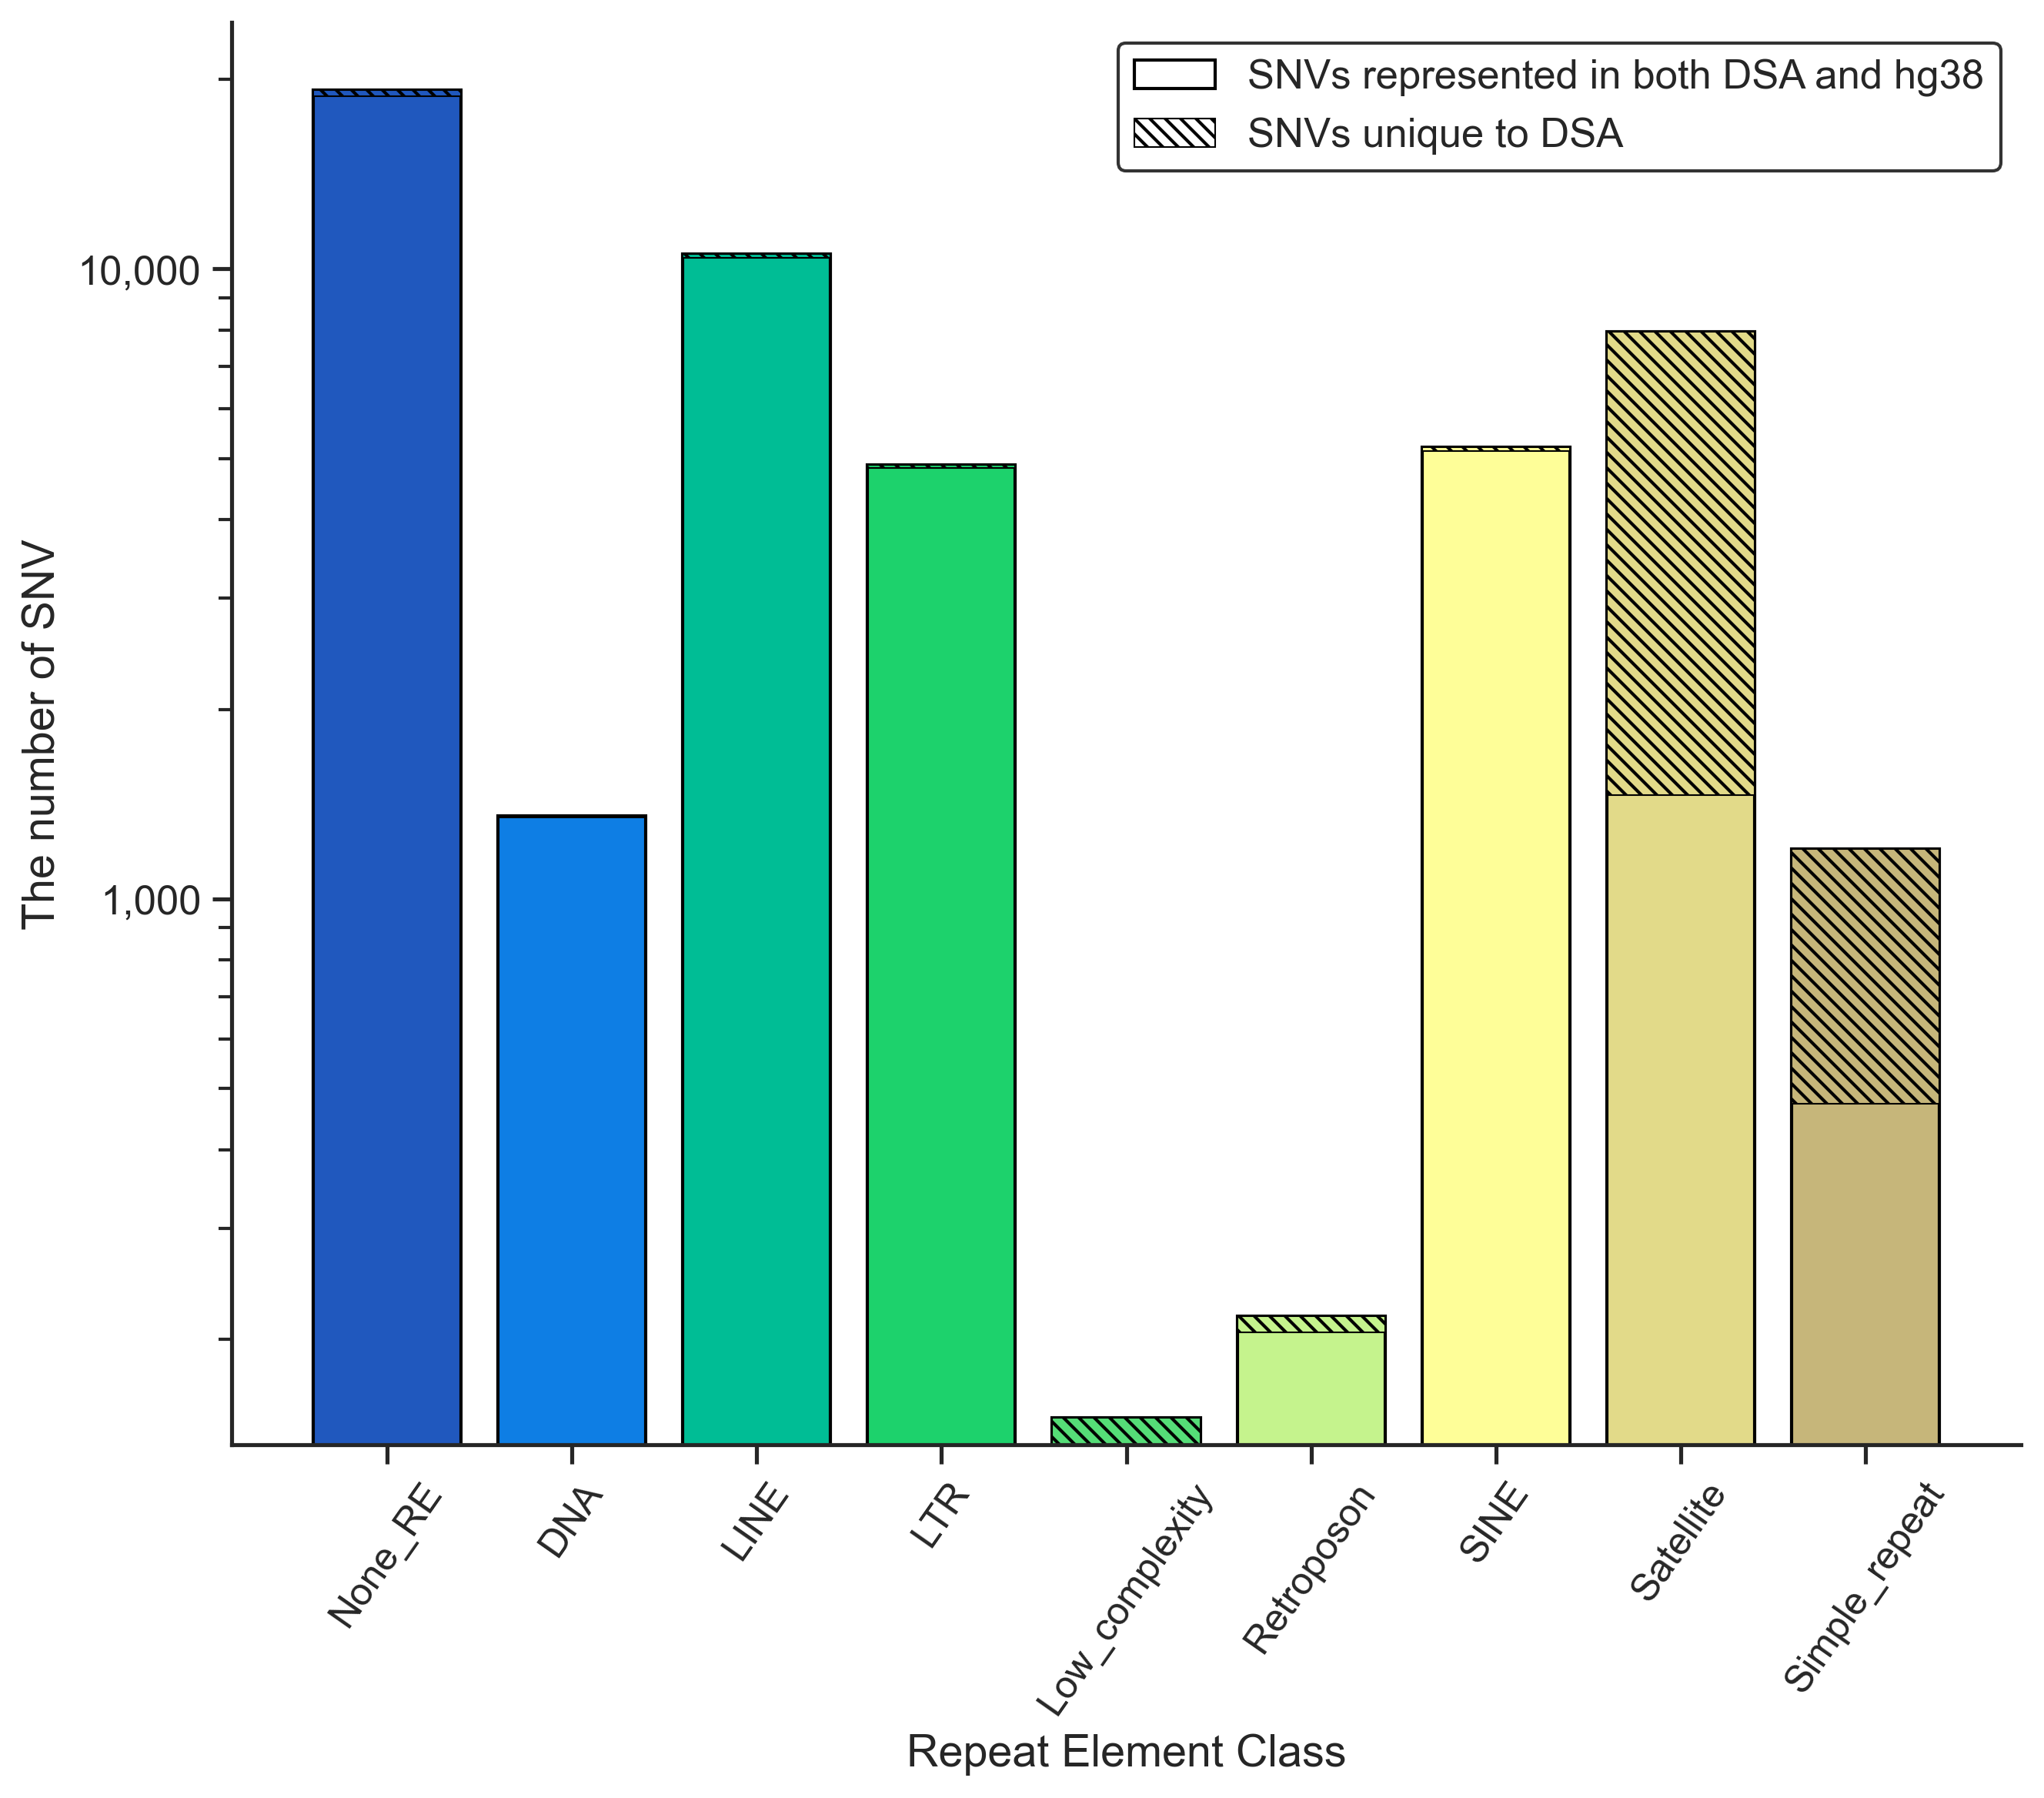

In [71]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.bar(rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'], rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_total'], label='SNVs represented in both DSA and hg38', edgecolor='black', color=[rec_color_map[i] for i in rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'].values])
ax.bar(rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'], rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_nonliftover'], bottom=rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_total'] - rec_snv_trimmed_merged_rec_liftoverreject_snv['SNV_count_nonliftover'], label='SNVs unique to DSA', edgecolor='black', linewidth=0.5, hatch='\\\\\\\\\\', color=[rec_color_map[i] for i in rec_snv_trimmed_merged_rec_liftoverreject_snv['repClass'].values])

ax.set_yscale('log')
ax.set_xlabel('Repeat Element Class')
ax.set_ylabel('The number of SNV')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))
ax.tick_params(axis='x', rotation=55, labelsize=12)

legend = ax.legend()
legend.get_frame().set_edgecolor('black')
legend.legend_handles[0].set_facecolor('white')
legend.legend_handles[1].set_facecolor('white')

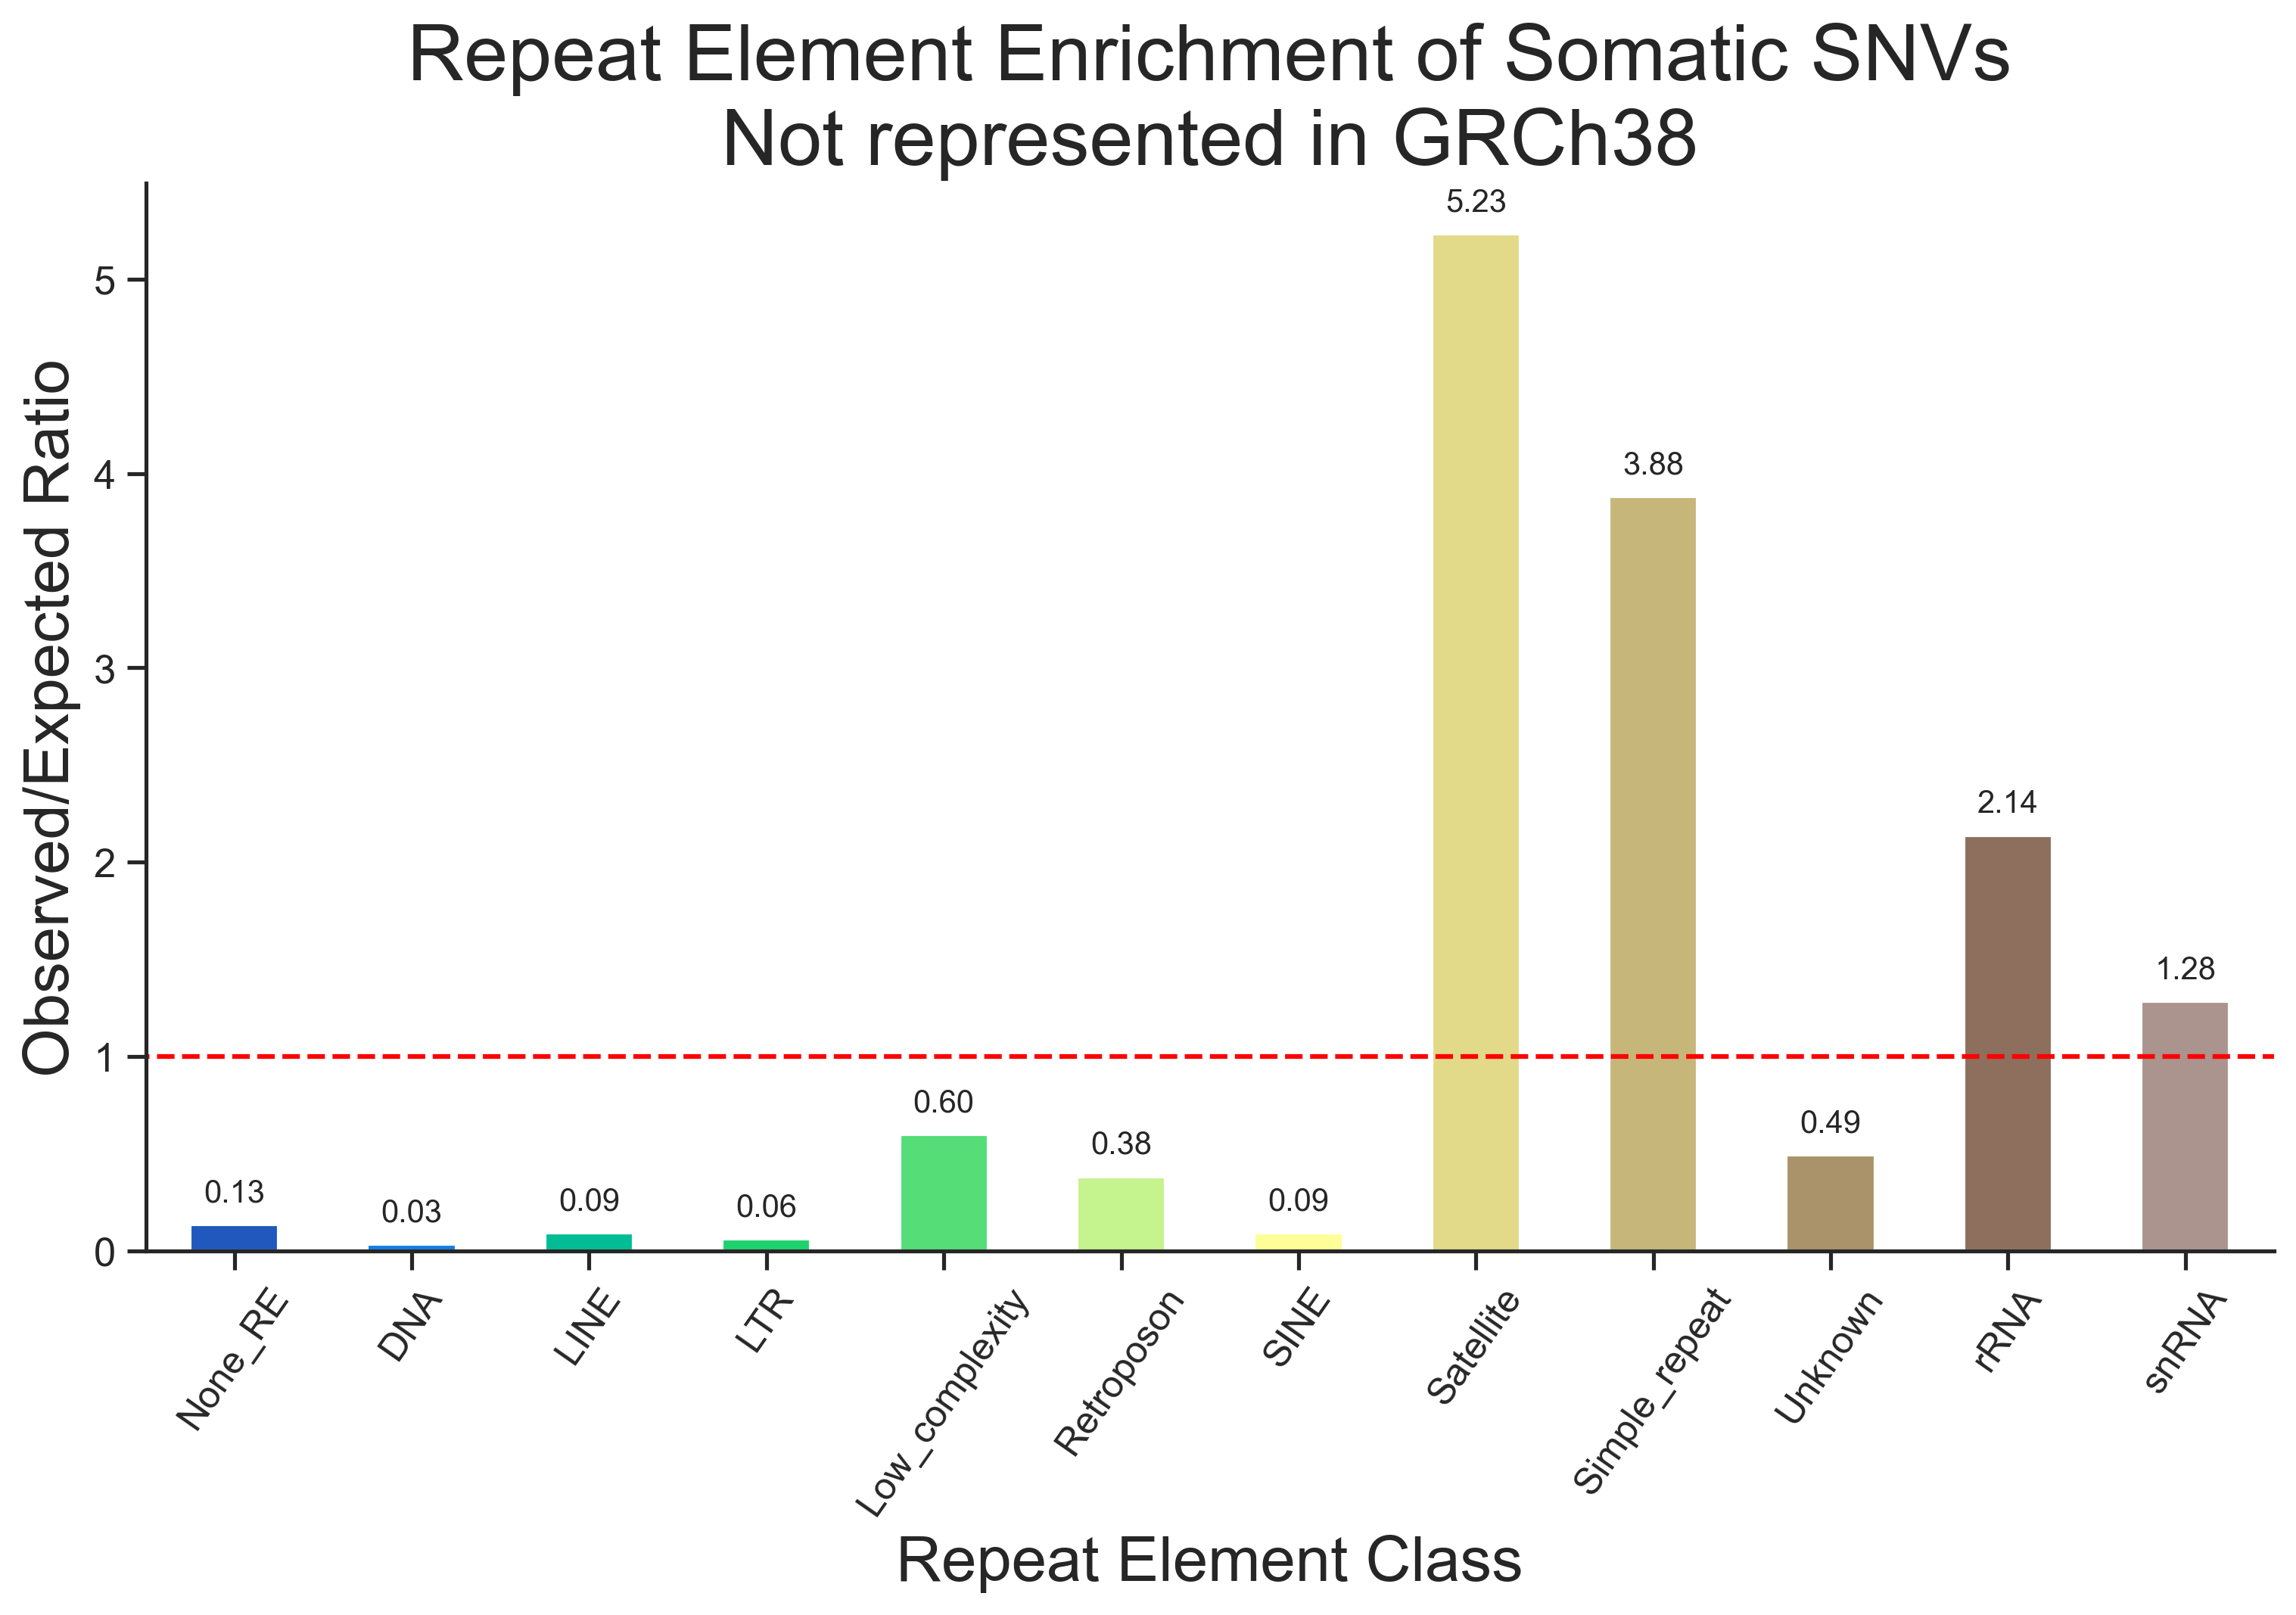

In [42]:
rec_liftoverreject_snv_obs_exp = pd.merge(rec_snv, rec_liftoverreject_snv, on="repClass", how="inner", suffixes=('_total', '_nonliftover'))
#repClass	SNV_count_x	Obs_Proportion_x	SNV_count_y	Obs_Proportion_y
#0	None_RE	19211	0.378341	403	0.050890
#1	DNA	1355	0.026685	7	0.000884
#2	LINE	10561	0.207988	152	0.019194
rec_liftoverreject_snv_obs_exp['Obs-Exp_Ratio'] = rec_liftoverreject_snv_obs_exp['Obs_Proportion_nonliftover'] / rec_liftoverreject_snv_obs_exp['Obs_Proportion_total']

fig, ax = plt.subplots(1, 1, figsize=(10, 7), constrained_layout=True)
rec_liftoverreject_snv_obs_exp.plot(kind="bar", x='repClass', y='Obs-Exp_Ratio', legend=None, color=[rec_color_map[i] for i in rec_liftoverreject_snv_obs_exp['repClass'].values], ax=ax)
ax.tick_params(axis='x', rotation=55, labelsize=12)
ax.set_title("Repeat Element Enrichment of Somatic SNVs\nNot represented in GRCh38", fontsize=25)
ax.set_xlabel("Repeat Element Class", fontsize=20)
ax.set_ylabel("Observed/Expected Ratio", fontsize=20)
ax.hlines(y=1, xmin=-1, xmax=rec_liftoverreject_snv_obs_exp.shape[0], color='red', linestyle='--')

for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=10, 
                textcoords='offset points')

In [9]:
# %%
# for None_RE: contingency_table: list[list[int, int], list[int, int]] = [[19299, 2777425039], [32475, 3281919225]]
#contingency_table = [[8441, 422289847],[43333, 5637106191]]
contingency_table = [[19299, 2777425039], [32475, 3281919225]]
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
n = np.sum(contingency_table)
cramersv = np.sqrt(chi2 / (n * (min(len(contingency_table), len(contingency_table[0])) - 1)))
print(n)
print(cramersv)

6059396038
0.0005022099632449364


In [64]:
colotb_snvs_shared_final_RM

0          1  2  3  4     5     6   \
0      haplotype1-0000001     345669  .  C  T  65.0  PASS   
1      haplotype1-0000001     381602  .  G  T  70.4  PASS   
2      haplotype1-0000001     436345  .  G  A  58.7  PASS   
3      haplotype1-0000001     493800  .  G  A  68.7  PASS   
4      haplotype1-0000001     547974  .  A  G  71.3  PASS   
...                   ...        ... .. .. ..   ...   ...   
50772  haplotype2-0000079  171196135  .  G  A  65.2  PASS   
50773  haplotype2-0000079  171240478  .  C  A  63.2  PASS   
50774  haplotype2-0000079  171322181  .  G  A  60.7  PASS   
50775  haplotype2-0000079  171322182  .  G  A  63.0  PASS   
50776  haplotype2-0000079  171499461  .  C  T  62.8  PASS   

                                                      7                   8   \
0                                 Flagger=Hap;RM=LINE/L1  GT:GQ:DP:AD:VAF:PL   
1                                 Flagger=Hap;RM=LINE/L1  GT:GQ:DP:AD:VAF:PL   
2      Flagger=Hap;TRF=trf_191/178.1/36/94/1.51,trf_1...  GT:GQ:DP:AD:VAF:PL   
3                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
4                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
...                                                  ...                 ...   
50772                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50773                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50774                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50775                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50776                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   

                                      9   ...      11      12     13    14 15  \
0      1/1:59:133:2,131:0.984962:65,60,0  ...  342600  348625  L1PA2  6025  -   
1             1/1:65:131:0,131:1:70,66,0  ...  380792  382481  L1PB1  1689  +   
2               1/1:53:49:0,49:1:58,54,0  ...      -1      -1      .     .  .   
3               1/1:63:83:0,83:1:68,63,0  ...      -1      -1      .     .  .   
4             1/1:65:123:0,123:1:71,66,0  ...      -1      -1      .     .  .   
...                                  ...  ...     ...     ...    ...   ... ..   
50772           1/1:62:43:0,43:1:65,65,0  ...      -1      -1      .     .  .   
50773           1/1:61:42:0,42:1:63,64,0  ...      -1      -1      .     .  .   
50774           1/1:55:57:0,57:1:60,56,0  ...      -1      -1      .     .  .   
50775           1/1:61:57:0,57:1:63,64,0  ...      -1      -1      .     .  .   
50776           1/1:59:53:0,53:1:62,62,0  ...      -1      -1      .     .  .   

         16  17    18   19 20  
0      LINE  L1  -1.0  480  1  
1      LINE  L1  -1.0  515  1  
2         .   .     .    .  0  
3         .   .     .    .  0  
4         .   .     .    .  0  
...     ...  ..   ...  ... ..  
50772     .   .     .    .  0  
50773     .   .     .    .  0  
50774     .   .     .    .  0  
50775     .   .     .    .  0  
50776     .   .     .    .  0  

[50777 rows x 21 columns]

In [80]:
pre_vcf = colotb_snvs_shared_final_RM[colotb_snvs_shared_final_RM.iloc[:,16] == "."].iloc[:, :10]
pre_vcf.columns = ['#CHROM','POS','ID','REF','ALT','QUAL','FILTER','INFO','FORMAT','COLO829T_PassageB_DSA']
pre_vcf

#CHROM        POS ID REF ALT  QUAL FILTER  \
2      haplotype1-0000001     436345  .   G   A  58.7   PASS   
3      haplotype1-0000001     493800  .   G   A  68.7   PASS   
4      haplotype1-0000001     547974  .   A   G  71.3   PASS   
5      haplotype1-0000001     607471  .   G   A  66.7   PASS   
8      haplotype1-0000001    1088640  .   G   A  65.4   PASS   
...                   ...        ... ..  ..  ..   ...    ...   
50772  haplotype2-0000079  171196135  .   G   A  65.2   PASS   
50773  haplotype2-0000079  171240478  .   C   A  63.2   PASS   
50774  haplotype2-0000079  171322181  .   G   A  60.7   PASS   
50775  haplotype2-0000079  171322182  .   G   A  63.0   PASS   
50776  haplotype2-0000079  171499461  .   C   T  62.8   PASS   

                                                    INFO              FORMAT  \
2      Flagger=Hap;TRF=trf_191/178.1/36/94/1.51,trf_1...  GT:GQ:DP:AD:VAF:PL   
3                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
4                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
5                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
8                                            Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
...                                                  ...                 ...   
50772                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50773                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50774                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50775                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   
50776                                        Flagger=Hap  GT:GQ:DP:AD:VAF:PL   

            COLO829T_PassageB_DSA  
2        1/1:53:49:0,49:1:58,54,0  
3        1/1:63:83:0,83:1:68,63,0  
4      1/1:65:123:0,123:1:71,66,0  
5      1/1:62:118:0,118:1:66,64,0  
8      1/1:61:129:0,129:1:65,62,0  
...                           ...  
50772    1/1:62:43:0,43:1:65,65,0  
50773    1/1:61:42:0,42:1:63,64,0  
50774    1/1:55:57:0,57:1:60,56,0  
50775    1/1:61:57:0,57:1:63,64,0  
50776    1/1:59:53:0,53:1:62,62,0  

[19211 rows x 10 columns]

## Segmental Dulications (Duplicons)

In [23]:
#vcf_info_getter(colotb_snvs_shared_final, 'DM')
colotb_snvs_shared_final_DM = colotb_snvs_shared_final[colotb_snvs_shared_final['INFO'].str.contains("DM=")].reset_index(drop=True) # Not sophisticated approach
colotb_snvs_shared_final_DM

CHROM        POS ID REF ALT  QUAL FILTER  \
0     haplotype1-0000001    2191504  .   G   A  66.7   PASS   
1     haplotype1-0000001    2210312  .   G   A  66.4   PASS   
2     haplotype1-0000001   11611326  .   G   A  68.9   PASS   
3     haplotype1-0000001   16780498  .   G   A  66.5   PASS   
4     haplotype1-0000001   19543481  .   C   T  62.6   PASS   
...                  ...        ... ..  ..  ..   ...    ...   
3178  haplotype2-0000079  161658574  .   C   T  65.9   PASS   
3179  haplotype2-0000079  161782724  .   G   A    15   PASS   
3180  haplotype2-0000079  161965273  .   G   A  70.1   PASS   
3181  haplotype2-0000079  168287076  .   C   A  62.7   PASS   
3182  haplotype2-0000079  168486529  .   C   T  61.3   PASS   

                                         INFO              FORMAT  \
0                Flagger=Hap;DM=SD4171,SD4840  GT:GQ:DP:AD:VAF:PL   
1                       Flagger=Hap;DM=SD9721  GT:GQ:DP:AD:VAF:PL   
2                       Flagger=Hap;DM=SD1005  GT:GQ:DP:AD:VAF:PL   
3           Flagger=Hap;RM=SINE/Alu;DM=SD6544  GT:GQ:DP:AD:VAF:PL   
4                       Flagger=Hap;DM=SD4132  GT:GQ:DP:AD:VAF:PL   
...                                       ...                 ...   
3178  Flagger=Hap;RM=LINE/L1;DM=SD8786,SD8786  GT:GQ:DP:AD:VAF:PL   
3179         Flagger=Hap;RM=LINE/L1;DM=SD6835  GT:GQ:DP:AD:VAF:PL   
3180                    Flagger=Hap;DM=SD8768  GT:GQ:DP:AD:VAF:PL   
3181        Flagger=Hap;RM=LTR/ERV1;DM=SD8777  GT:GQ:DP:AD:VAF:PL   
3182                    Flagger=Hap;DM=SD8777  GT:GQ:DP:AD:VAF:PL   

                 COLO829T_PassageB_DSA  
0           1/1:64:116:0,116:1:66,66,0  
1           1/1:60:133:0,133:1:66,61,0  
2           1/1:64:100:0,100:1:68,65,0  
3             1/1:59:91:0,91:1:66,60,0  
4             1/1:60:56:0,56:1:62,64,0  
...                                ...  
3178          1/1:64:51:0,51:1:65,67,0  
3179  0/1:15:53:35,17:0.320755:14,0,48  
3180          1/1:67:55:0,55:1:70,70,0  
3181          1/1:59:51:0,51:1:62,61,0  
3182   1/1:57:46:0,45:0.978261:61,59,0  

[3183 rows x 10 columns]

In [37]:
from scipy.stats import fisher_exact
nonsd_size = 5_479_216_485 #  bedtools subtract -a DSA_COLO829BL_v3.0.0_Flagger-NucFlag_removed.bed.gz -b Intersect_DM_WITH_DSA_COLO829BL_v3.0.0_Flagger-NucFlag_removed.bed.gz | awk 'BEGIN {sum=0} {sum+=($3-$2)} END {print sum}'
hapsize = 5_838_108_459 # zcat DSA_COLO829BL_v3.0.0_Flagger-NucFlag_removed.bed.gz | awk 'BEGIN {sum=0} {sum+=($3-$2)} END {print sum}'
sd_size = hapsize - nonsd_size
sd_expected = sd_size / hapsize
sd_snv_observed = colotb_snvs_shared_final_DM.shape[0] / colotb_snvs_shared_final.shape[0]
print(f"Size of the Segmentally Duplicated region in the COLO829BL Diploid DSA is: {sd_size:,} bp")
print(f"Enrichment of SNV in SD regions: {sd_snv_observed / sd_expected:.3f}")

contingency_table = [[colotb_snvs_shared_final_DM.shape[0], (colotb_snvs_shared_final.shape[0] - colotb_snvs_shared_final_DM.shape[0])],
                     [sd_size, nonsd_size]]

print(fisher_exact(contingency_table, alternative='two-sided'))

Size of the Segmentally Duplicated region in the COLO829BL Diploid DSA is: 358,891,974 bp
Enrichment of SNV in SD regions: 1.021
SignificanceResult(statistic=1.022922868584386, pvalue=0.21536329484848682)


## Mutational Spectrum Analysis on Different REs

### Generate VCFs for mutyper

In [73]:
mutspectrumdir="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/Annotation/SNVs/Rhodonite/Mutational_Spectrum"

In [ ]:
bgzip="/mmfs1/gscratch/stergachislab/mhsohny/Miniconda/bin/bgzip"
tabix="/mmfs1/gscratch/stergachislab/mhsohny/Miniconda/bin/tabix"

os.system(f"mkdir -p {mutspectrumdir}")
os.system(f"mkdir -p {mutspectrumdir}/01.SBS")

os.system(f"zcat {snvdir}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.shared.final.vcf.gz \
          | awk '/^##/' \
          > {mutspectrumdir}/01.SBS/pseudovcf_header")

# For None_RE
retype = "None_RE"
os.system(f"mkdir -p {mutspectrumdir}/01.SBS/{retype}")
pre_vcf = colotb_snvs_shared_final_RM[colotb_snvs_shared_final_RM.iloc[:,16] == "."].iloc[:, :10]
pre_vcf.columns = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'COLO829T_PassageB_DSA']
pre_vcf.to_csv(f"{mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.pre.vcf", sep="\t", index=False)

os.system(f"cat {mutspectrumdir}/01.SBS/pseudovcf_header \
          {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.pre.vcf \
            > {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.vcf")

os.system(f"{bgzip} -f {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.vcf \
          && {tabix} -p vcf {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.vcf.gz")

os.system(f"rm {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.pre.vcf")

# For REs
for retype in ['DNA', 'LINE', 'LTR', 'Low_complexity', 'Retroposon', 'SINE', 'Satellite', 'Simple_repeat']:
      os.system(f"mkdir -p {mutspectrumdir}/01.SBS/{retype}")
      
      pre_vcf = colotb_snvs_shared_final_RM[colotb_snvs_shared_final_RM.iloc[:,16] == f"{retype}"].iloc[:, :10]
      pre_vcf.columns = ['#CHROM', 'POS', 'ID', 'REF', 'ALT', 'QUAL', 'FILTER', 'INFO', 'FORMAT', 'COLO829T_PassageB_DSA']
      pre_vcf.to_csv(f"{mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.pre.vcf", sep="\t", index=False)
      
      os.system(f"cat {mutspectrumdir}/01.SBS/pseudovcf_header \
                {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.pre.vcf \
                  > {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.vcf")
      
      os.system(f"{bgzip} -f {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.vcf \
                && {tabix} -p vcf {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.vcf.gz")
      
      os.system(f"rm {mutspectrumdir}/01.SBS/{retype}/COLO829T_PassageB_DSA.deepvariant.PASS.snv.annot.{retype}.pre.vcf")

## mutyper Run on Cluster

## SigProfiler Runs

In [87]:
import sigProfilerPlotting as sigPlt
from SigProfilerAssignment import Analyzer as Analyze

sns.set_theme(font="Arial", font_scale=1.1, style='ticks')
plt.rc("axes.spines", top=True, right=True)

def reverse_complement(string):
    try:
        complement_dict = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
        complement_string = ''.join([complement_dict[s] for s in string])
    except KeyError:
        raise ValueError("Invalid character other than A,T,G and C")
    return complement_string[::-1]

def trinuc_context_change(string):
    # ex. AAC>ACC => GTT>GGT
    if len(string) != 7 or string[3] != '>':
        raise ValueError("Input string must be in the format 'NNN>NNN'")
    
    if string[1] not in ['C', 'T']:
        string_pair = string.split('>')
        new_string = reverse_complement(string_pair[0]) + '>' + reverse_complement(string_pair[1])
    else:
        new_string = string
    return new_string

sbs6 = ("C>A", "C>G", "C>T", "T>A", "T>C", "T>G") # Should make also .SBS6.all

sbs96_sigprofiler="""A[C>A]A	A[C>A]C	A[C>A]G	A[C>A]T	A[C>G]A	A[C>G]C	A[C>G]G	A[C>G]T	A[C>T]A	A[C>T]C	A[C>T]G	A[C>T]T	A[T>A]A	A[T>A]C	A[T>A]G	A[T>A]T	A[T>C]A	A[T>C]C	A[T>C]G	A[T>C]T	A[T>G]A	A[T>G]C	A[T>G]G	A[T>G]T	C[C>A]A	C[C>A]C	C[C>A]G	C[C>A]T	C[C>G]A	C[C>G]C	C[C>G]G	C[C>G]T	C[C>T]A	C[C>T]C	C[C>T]G	C[C>T]T	C[T>A]A	C[T>A]C	C[T>A]G	C[T>A]T	C[T>C]A	C[T>C]C	C[T>C]G	C[T>C]T	C[T>G]A	C[T>G]C	C[T>G]G	C[T>G]T	G[C>A]A	G[C>A]C	G[C>A]G	G[C>A]T	G[C>G]A	G[C>G]C	G[C>G]G	G[C>G]T	G[C>T]A	G[C>T]C	G[C>T]G	G[C>T]T	G[T>A]A	G[T>A]C	G[T>A]G	G[T>A]T	G[T>C]A	G[T>C]C	G[T>C]G	G[T>C]T	G[T>G]A	G[T>G]C	G[T>G]G	G[T>G]T	T[C>A]A	T[C>A]C	T[C>A]G	T[C>A]T	T[C>G]A	T[C>G]C	T[C>G]G	T[C>G]T	T[C>T]A	T[C>T]C	T[C>T]G	T[C>T]T	T[T>A]A	T[T>A]C	T[T>A]G	T[T>A]T	T[T>C]A	T[T>C]C	T[T>C]G	T[T>C]T	T[T>G]A	T[T>G]C	T[T>G]G	T[T>G]T"""
sbs96_sigprofiler = sbs96_sigprofiler.split()

sbs96 = dict()
for sbs in sbs96_sigprofiler:
    sbs96[f'{sbs[0]}{sbs[2]}{sbs[-1]}>{sbs[0]}{sbs[-3]}{sbs[-1]}'] = sbs

In [113]:
dir="/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/Improving_SomaticVariantCalling_through_DSA/Fiber-seq/VariantCalls_DeepVariant_1.6.1/Annotation/SNVs/Rhodonite/Mutational_Spectrum/01.SBS"
#COLO829T_PassageB_DSA.Simple_repeat.SBS96
sample="COLO829T_PassageB_DSA"

for retype in ['None_RE', 'DNA', 'LINE', 'LTR', 'Low_complexity', 'Retroposon', 'SINE', 'Satellite', 'Simple_repeat']:

    df = pd.read_csv(f"{dir}/{retype}/{sample}.{retype}.SBS96", sep="\t", header=None).T
    df.columns = ['SBS96_pre', 'Count']

    mutyper_trinuc = [
    'AAA>ACA', 'AAA>AGA', 'AAA>ATA', 'AAC>ACC', 'AAC>AGC', 'AAC>ATC',
    'AAG>ACG', 'AAG>AGG', 'AAG>ATG', 'AAT>ACT', 'AAT>AGT', 'AAT>ATT',
    'ACA>AAA', 'ACA>AGA', 'ACA>ATA', 'ACC>AAC', 'ACC>AGC', 'ACC>ATC',
    'ACG>AAG', 'ACG>AGG', 'ACG>ATG', 'ACT>AAT', 'ACT>AGT', 'ACT>ATT',
    'CAA>CCA', 'CAA>CGA', 'CAA>CTA', 'CAC>CCC', 'CAC>CGC', 'CAC>CTC',
    'CAG>CCG', 'CAG>CGG', 'CAG>CTG', 'CAT>CCT', 'CAT>CGT', 'CAT>CTT',
    'CCA>CAA', 'CCA>CGA', 'CCA>CTA', 'CCC>CAC', 'CCC>CGC', 'CCC>CTC',
    'CCG>CAG', 'CCG>CGG', 'CCG>CTG', 'CCT>CAT', 'CCT>CGT', 'CCT>CTT',
    'GAA>GCA', 'GAA>GGA', 'GAA>GTA', 'GAC>GCC', 'GAC>GGC', 'GAC>GTC',
    'GAG>GCG', 'GAG>GGG', 'GAG>GTG', 'GAT>GCT', 'GAT>GGT', 'GAT>GTT',
    'GCA>GAA', 'GCA>GGA', 'GCA>GTA', 'GCC>GAC', 'GCC>GGC', 'GCC>GTC',
    'GCG>GAG', 'GCG>GGG', 'GCG>GTG', 'GCT>GAT', 'GCT>GGT', 'GCT>GTT',
    'TAA>TCA', 'TAA>TGA', 'TAA>TTA', 'TAC>TCC', 'TAC>TGC', 'TAC>TTC',
    'TAG>TCG', 'TAG>TGG', 'TAG>TTG', 'TAT>TCT', 'TAT>TGT', 'TAT>TTT',
    'TCA>TAA', 'TCA>TGA', 'TCA>TTA', 'TCC>TAC', 'TCC>TGC', 'TCC>TTC',
    'TCG>TAG', 'TCG>TGG', 'TCG>TTG', 'TCT>TAT', 'TCT>TGT', 'TCT>TTT'
    ]

    mutyper_template = pd.DataFrame({
        'SBS96_pre': mutyper_trinuc,
        'Count': 0
        })

    df = mutyper_template.merge(df, on="SBS96_pre", how='left', suffixes=('', '_new'))
    df['Count'] = df['Count_new'].fillna(0)
    df = df.drop(columns=['Count_new'])
    
    df['SBS96'] = df['SBS96_pre'].apply(trinuc_context_change)
    df['SBS96_SigProfiler'] = df['SBS96'].apply(lambda x: sbs96.get(x, None))

    df['SBS96_SigProfiler'] = pd.Categorical(df['SBS96_SigProfiler'], categories=sbs96_sigprofiler, ordered=True)
    """
    ['T[T>G]T', 'T[T>C]T', 'T[T>A]T', 'G[T>G]T', 'G[T>C]T', ..., 'T[C>G]G', 'T[C>T]G', 'T[C>A]T', 'T[C>G]T', 'T[C>T]T']
    Length: 96
    Categories (96, object): ['A[C>A]A' < 'A[C>A]C' < 'A[C>A]G' < 'A[C>A]T' ... 'T[T>G]A' < 'T[T>G]C' < 'T[T>G]G' < 'T[T>G]T']
    """
    df = df.sort_values(by='SBS96_SigProfiler').reset_index(drop=True)

    df.rename(columns={'SBS96_SigProfiler': 'MutationType', 'Count': f'{sample}'}, inplace=True)

    df[['MutationType', f'{sample}']].to_csv(f"{dir}/{retype}/{sample}.{retype}.SBS96.all", sep='\t', index=False)

In [114]:
for retype in ['None_RE', 'DNA', 'LINE', 'LTR', 'Low_complexity', 'Retroposon', 'SINE', 'Satellite', 'Simple_repeat']:
    print(retype)
    sigPlt.plotSBS(
        matrix_path=f"{dir}/{retype}/{sample}.{retype}.SBS96.all",
        output_path=f"{dir}/{retype}",
        project=f"{sample}",
        plot_type="96",
        savefig_format="pdf",
        percentage=False)

    sigPlt.plotSBS(
        matrix_path=f"{dir}/{retype}/{sample}.{retype}.SBS96.all",
        output_path=f"{dir}/{retype}",
        project=f"{sample}.percentage",
        plot_type="96",
        savefig_format="pdf",
        percentage=True)
    
    print('Fit COSMIC Database')
    Analyze.cosmic_fit(
        f"{dir}/{retype}/{sample}.{retype}.SBS96.all",
        f"{dir}/{retype}",
        input_type="matrix",
        context_type="96",
        collapse_to_SBS96=True,
        cosmic_version=3.4,
        exome=False,
        genome_build="GRCh38",
        signature_database=None,
        exclude_signature_subgroups=None,
        export_probabilities=True,
        export_probabilities_per_mutation=False,
        make_plots=True,
        sample_reconstruction_plots="pdf",
        verbose=False)

None_RE
Fit COSMIC Database
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 1/1 [100%] in 1.1s (0.87/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
DNA
Fit COSMIC Database
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 1/1 [100%] in 0.8s (1.20/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
LINE
Fit COSMIC Database
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 1/1 [100%] in 0.7s (1.41/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
LTR
Fit COSMIC Database
Assigning COSMIC sigs or Signature Database ...... 
|████████████████████████████████████████| 1/1 [100%] in 0.7s (1.41/s) 


 
Your Job Is Successfully Completed! Thank You For Using SigProfilerAssignment.
 
Low_complexity
Fit COSMIC Database
Assigning COSMIC sigs or Sig

In [ ]:
for retype in ['None_RE', 'DNA', 'LINE', 'LTR', 'Low_complexity', 'Retroposon', 'SINE', 'Satellite', 'Simple_repeat']:
    os.system(f"mv {mutspectrumdir}/01.SBS/{retype}/Assignment_Solution/Activities/SampleReconstruction/Reconstructed_Sample_Plots_96.pdf {mutspectrumdir}/01.SBS/{retype}/Assignment_Solution/Activities/SampleReconstruction/{retype}_Reconstructed_Sample_Plots_96.pdf")

[Text(0, 0, 'None_RE'),
 Text(1, 0, 'DNA'),
 Text(2, 0, 'LINE'),
 Text(3, 0, 'LTR'),
 Text(4, 0, 'Low_Complexity'),
 Text(5, 0, 'Retroposon'),
 Text(6, 0, 'SINE'),
 Text(7, 0, 'Satellite'),
 Text(8, 0, 'Simple_Repeat')]

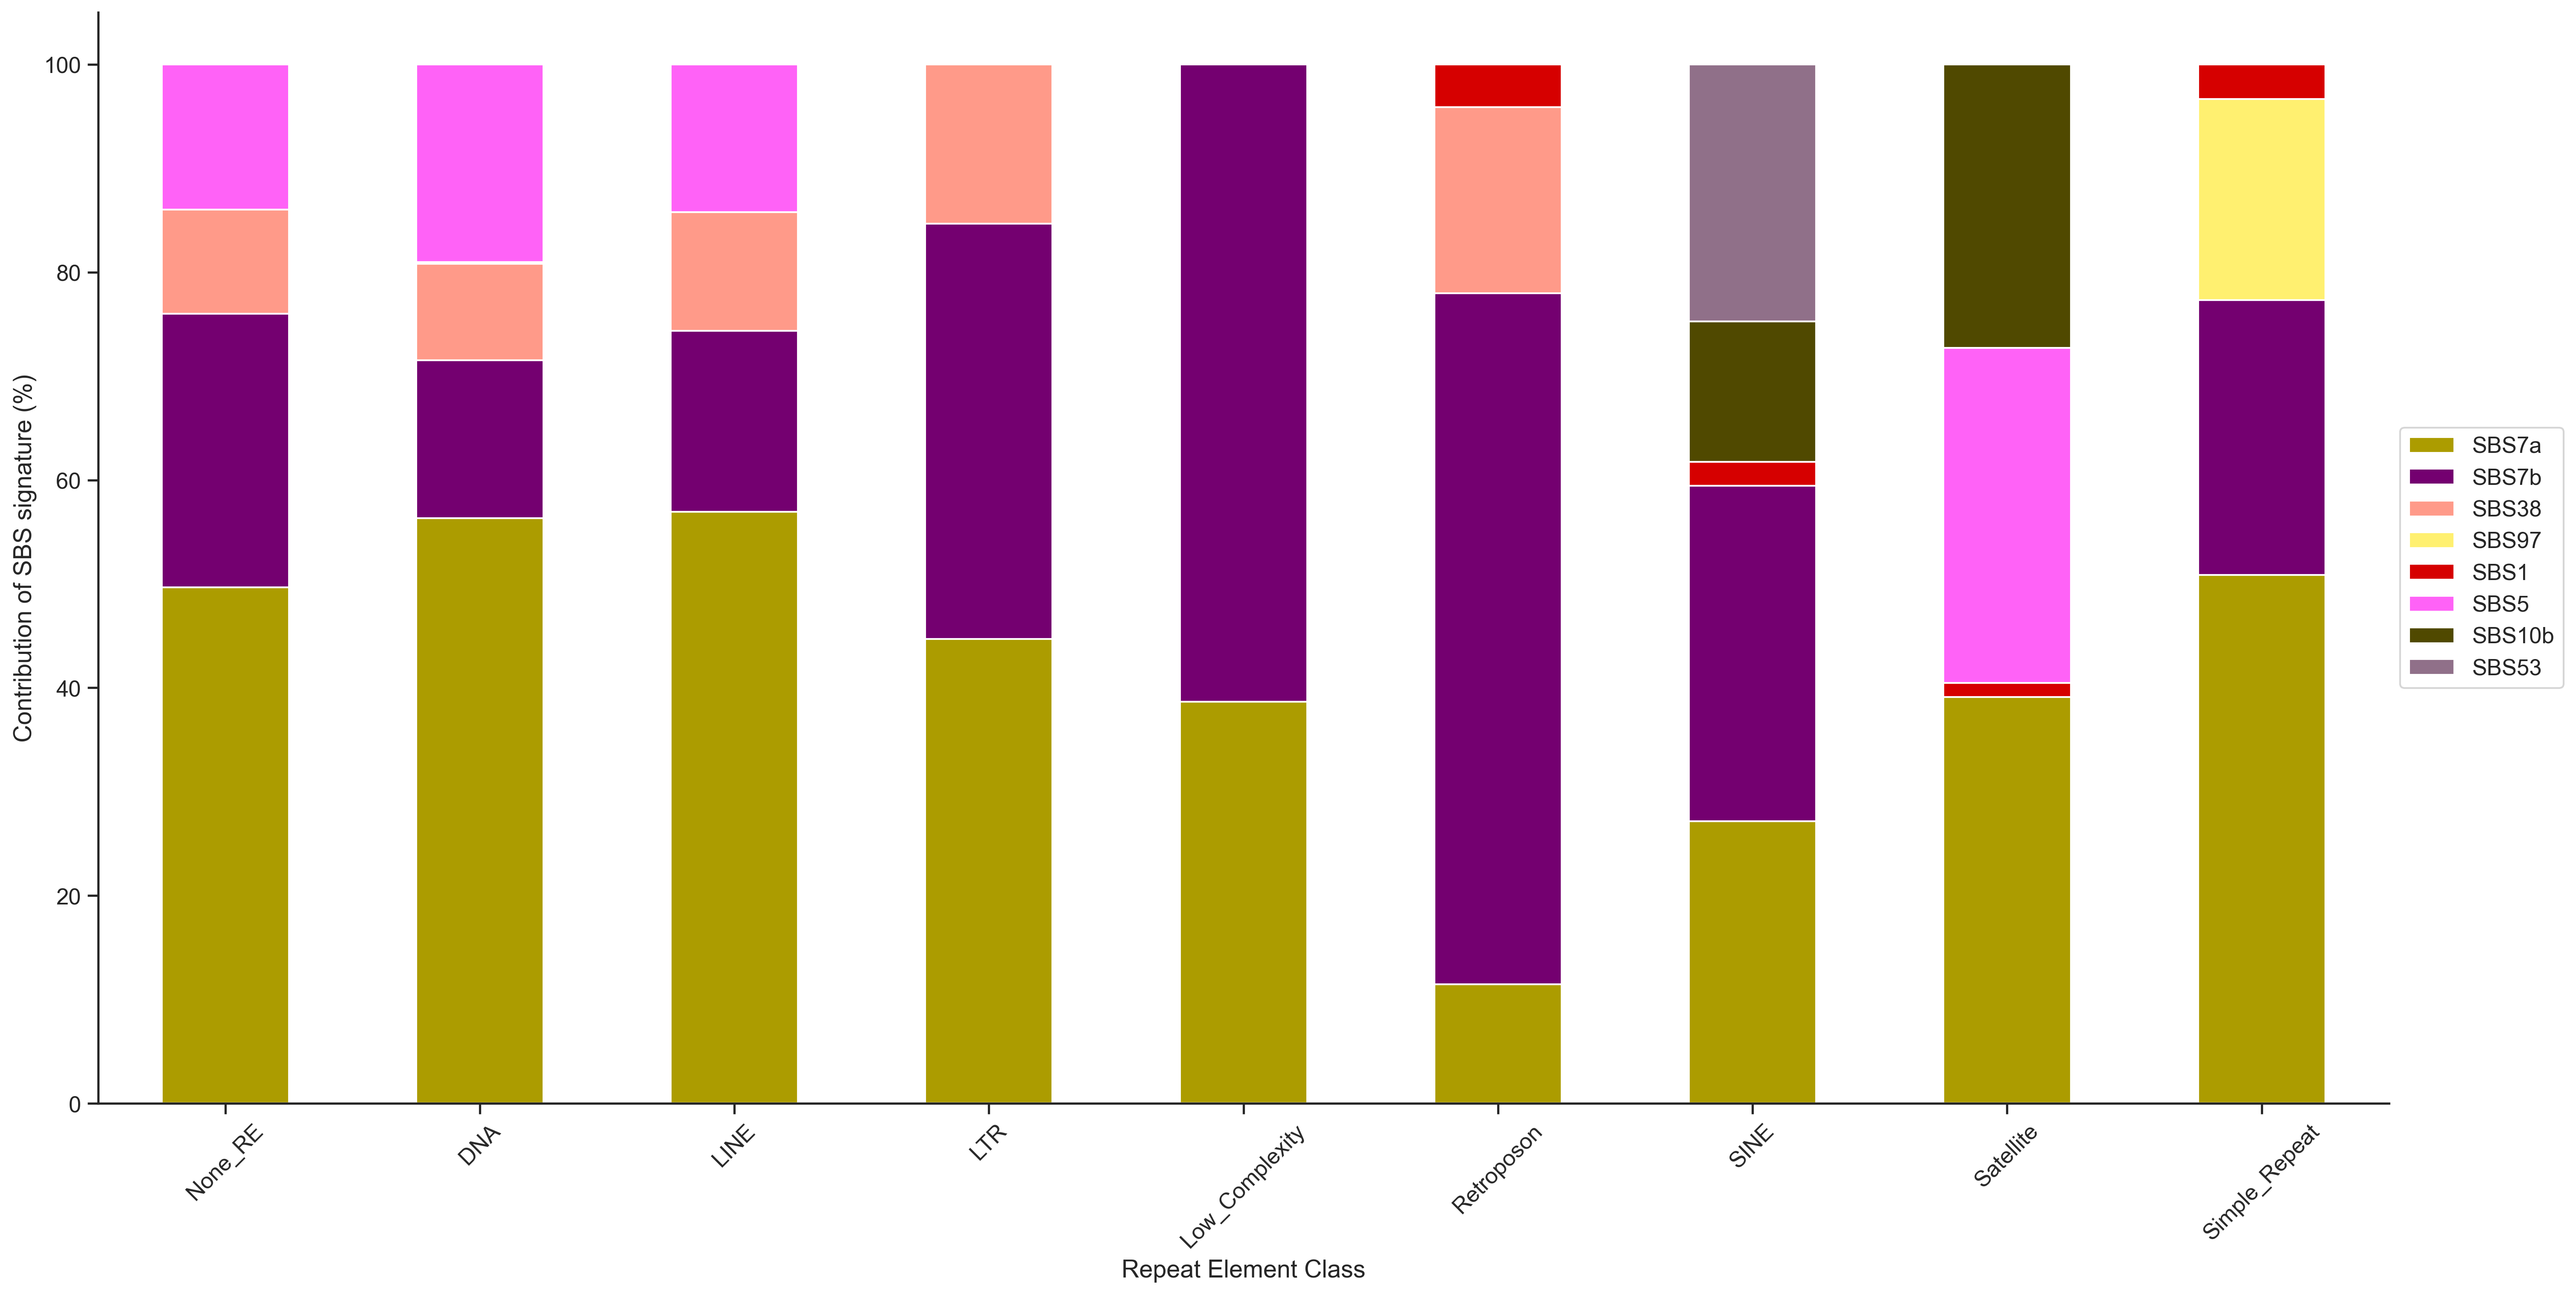

In [77]:
df = pd.read_csv(f"{mutspectrumdir}/01.SBS/Merged_Assignment_Solution_Activities.txt", sep="\t")
df.set_index('Samples', inplace=True)

df_percentage = df.div(df.sum(axis=1), axis=0) * 100
df_percentage = df_percentage.loc[:, (df_percentage != 0).any(axis=0)]

df_percentage_order = ["None_RE", "DNA", "LINE", "LTR", "Low_Complexity", "Retroposon", "SINE", "Satellite", "Simple_Repeat"]
df_percentage_sbs_order = ["SBS7a", "SBS7b", "SBS38", "SBS97", "SBS1", "SBS5", "SBS10b", "SBS53"]

fig, ax = plt.subplots(1,1, figsize=(20,10), constrained_layout=True)
df_percentage.reindex(df_percentage_order)[df_percentage_sbs_order].plot(kind='bar', stacked=True, legend=None, color=dict(zip(df_percentage.columns, sns.color_palette(cc.glasbey_warm, n_colors=len(df_percentage.columns)))), ax=ax)
ax.set_xlabel("Repeat Element Class")
ax.set_ylabel("Contribution of SBS signature (%)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

#plt.subplots_adjust(wspace=0)
#plt.savefig("test2.pdf")

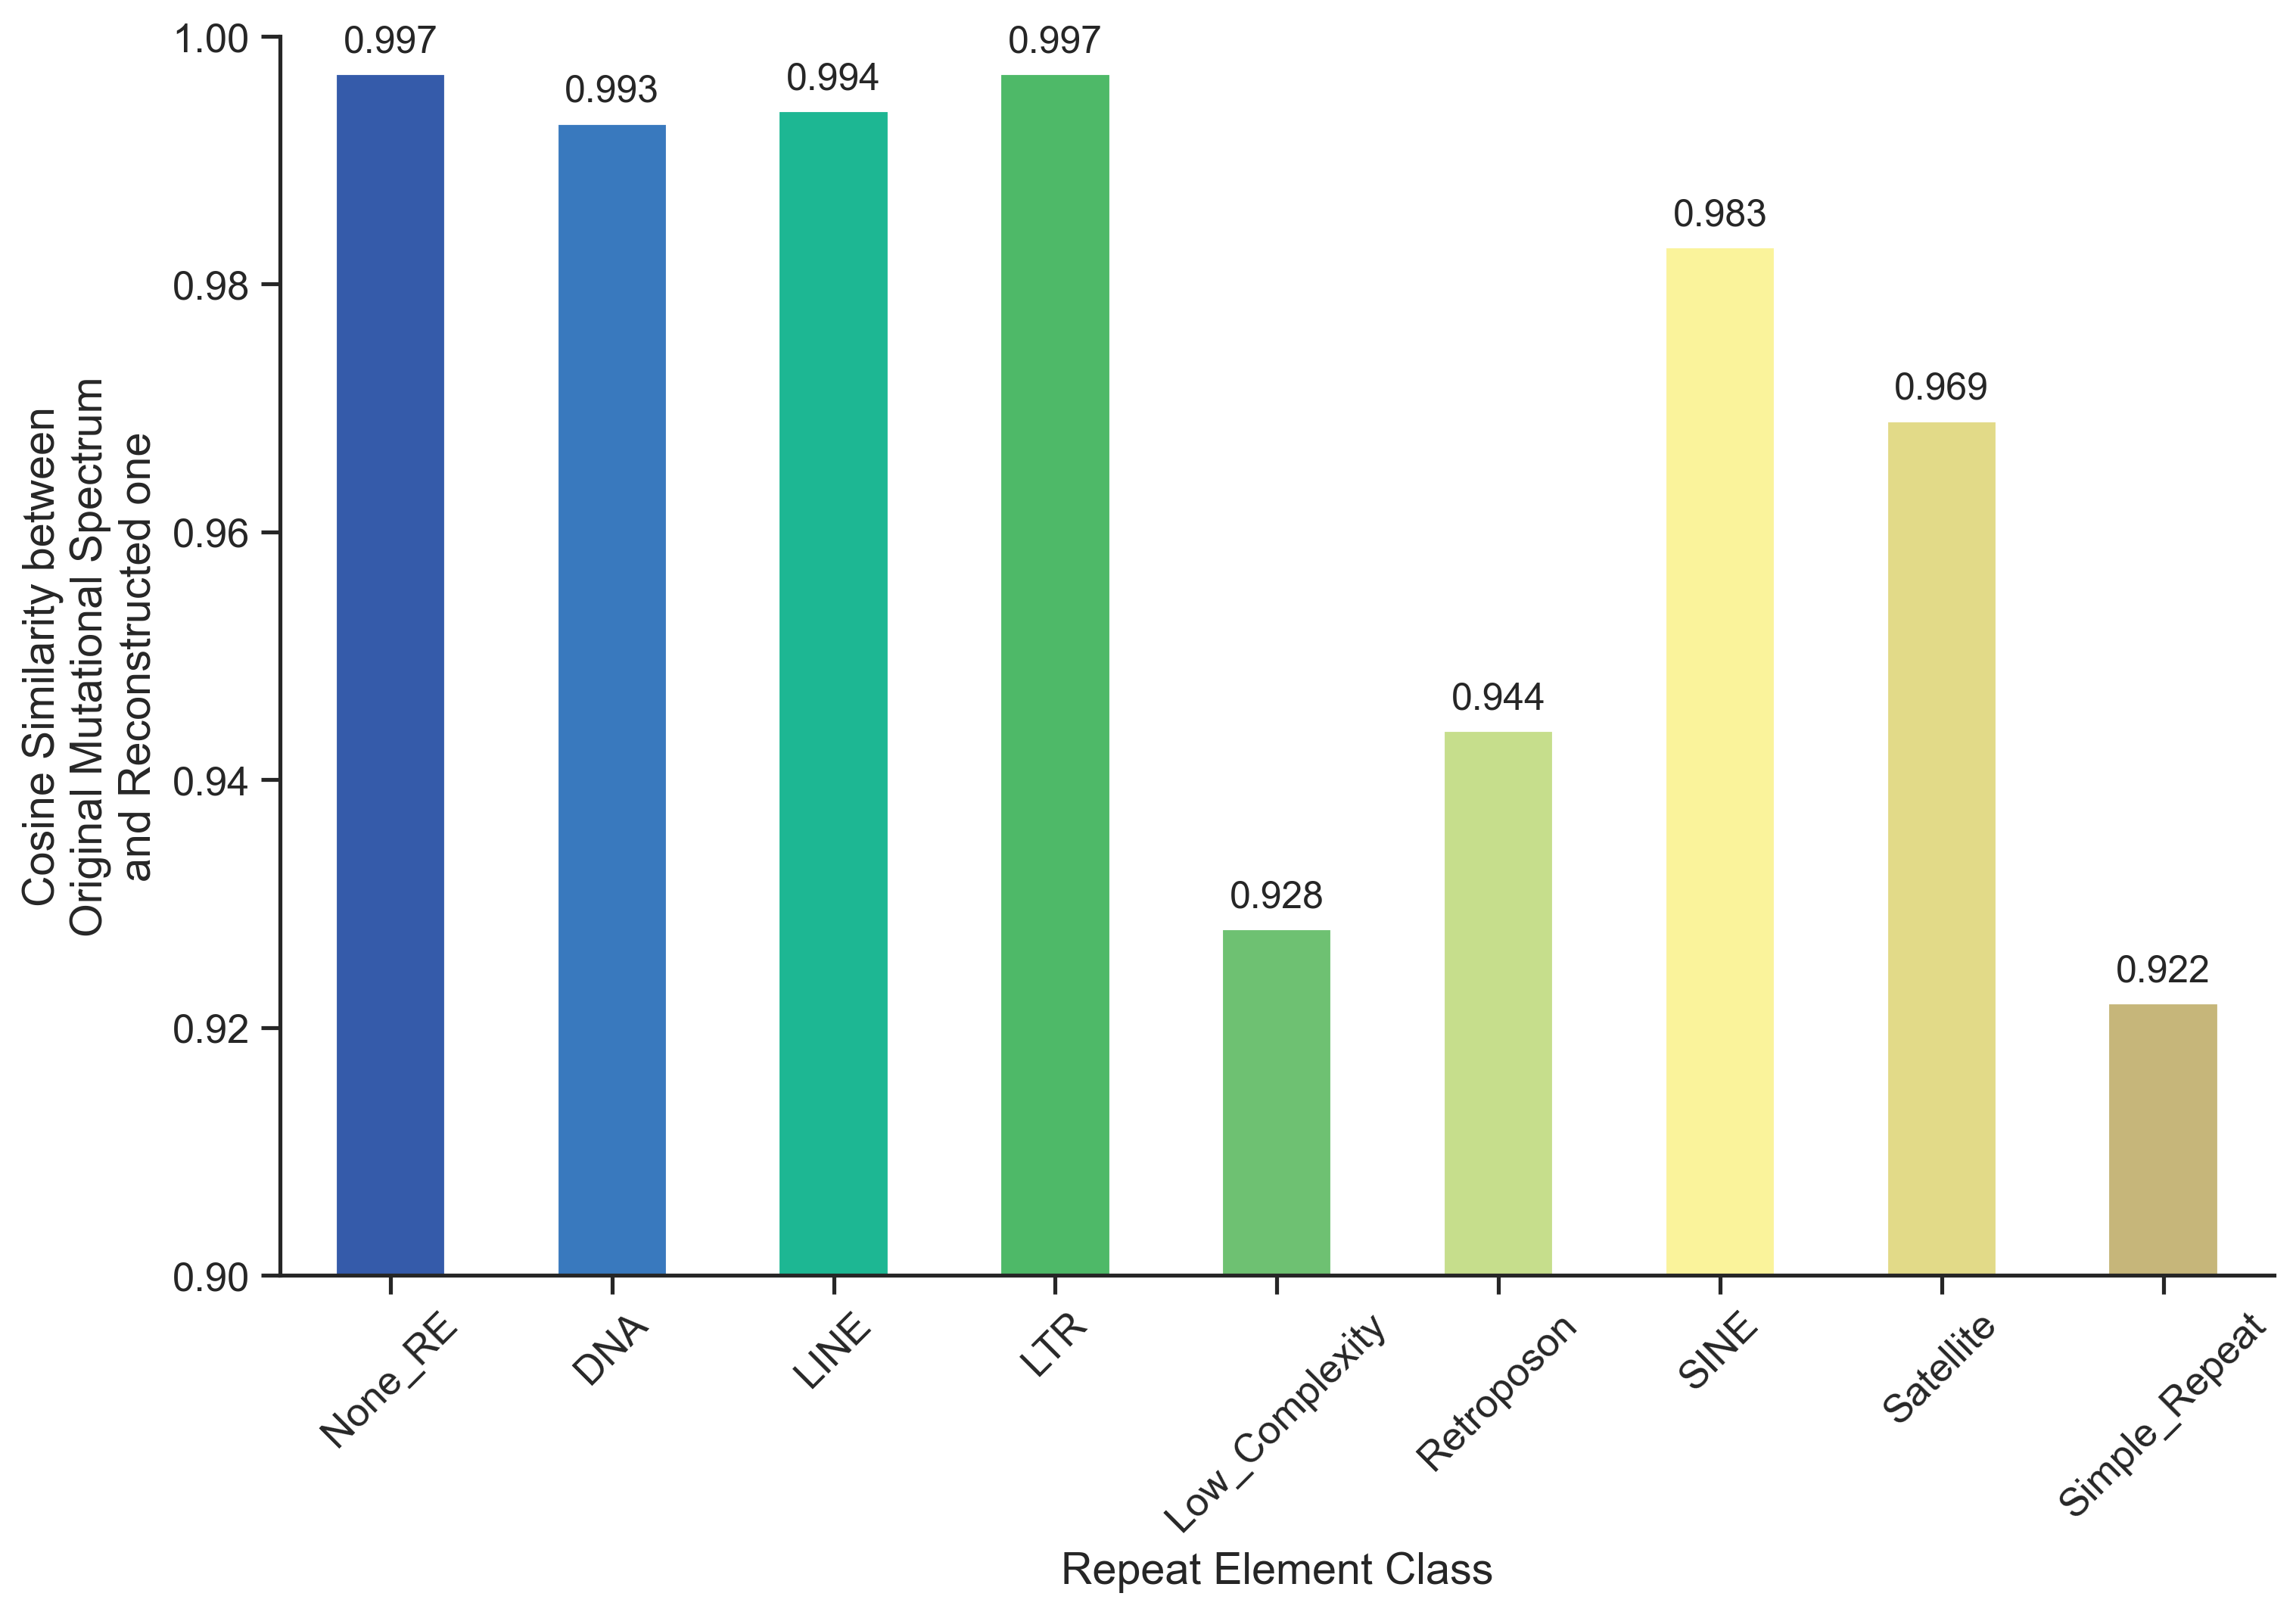

In [78]:
cosine_similarity = [.993, .994, .928, .997, .997, .944, .969, .922, .983]
df_cosine = pd.DataFrame(list(dict(zip(df_percentage.index, cosine_similarity)).items()), columns=['RE', 'Cosine Similarity']).set_index('RE')

fig, ax = plt.subplots(1,1, figsize=(10, 7), constrained_layout=True)
df_cosine.reindex(df_percentage_order).reset_index().plot(kind='bar', x="RE", y="Cosine Similarity",color=["#355BAA", "#3979BE", "#1DB793", "#4EB968", "#6EC172", "#C6DE8C", "#FAF39B", "#E2DA88", "#C6B67A"], legend=None, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_ylabel("Cosine Similarity between\nOriginal Mutational Spectrum\nand Reconstructed one")
ax.set_xlabel("Repeat Element Class")
ax.set_ylim(0.9, 1.0)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,.3f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                fontsize=12, 
                textcoords='offset points')

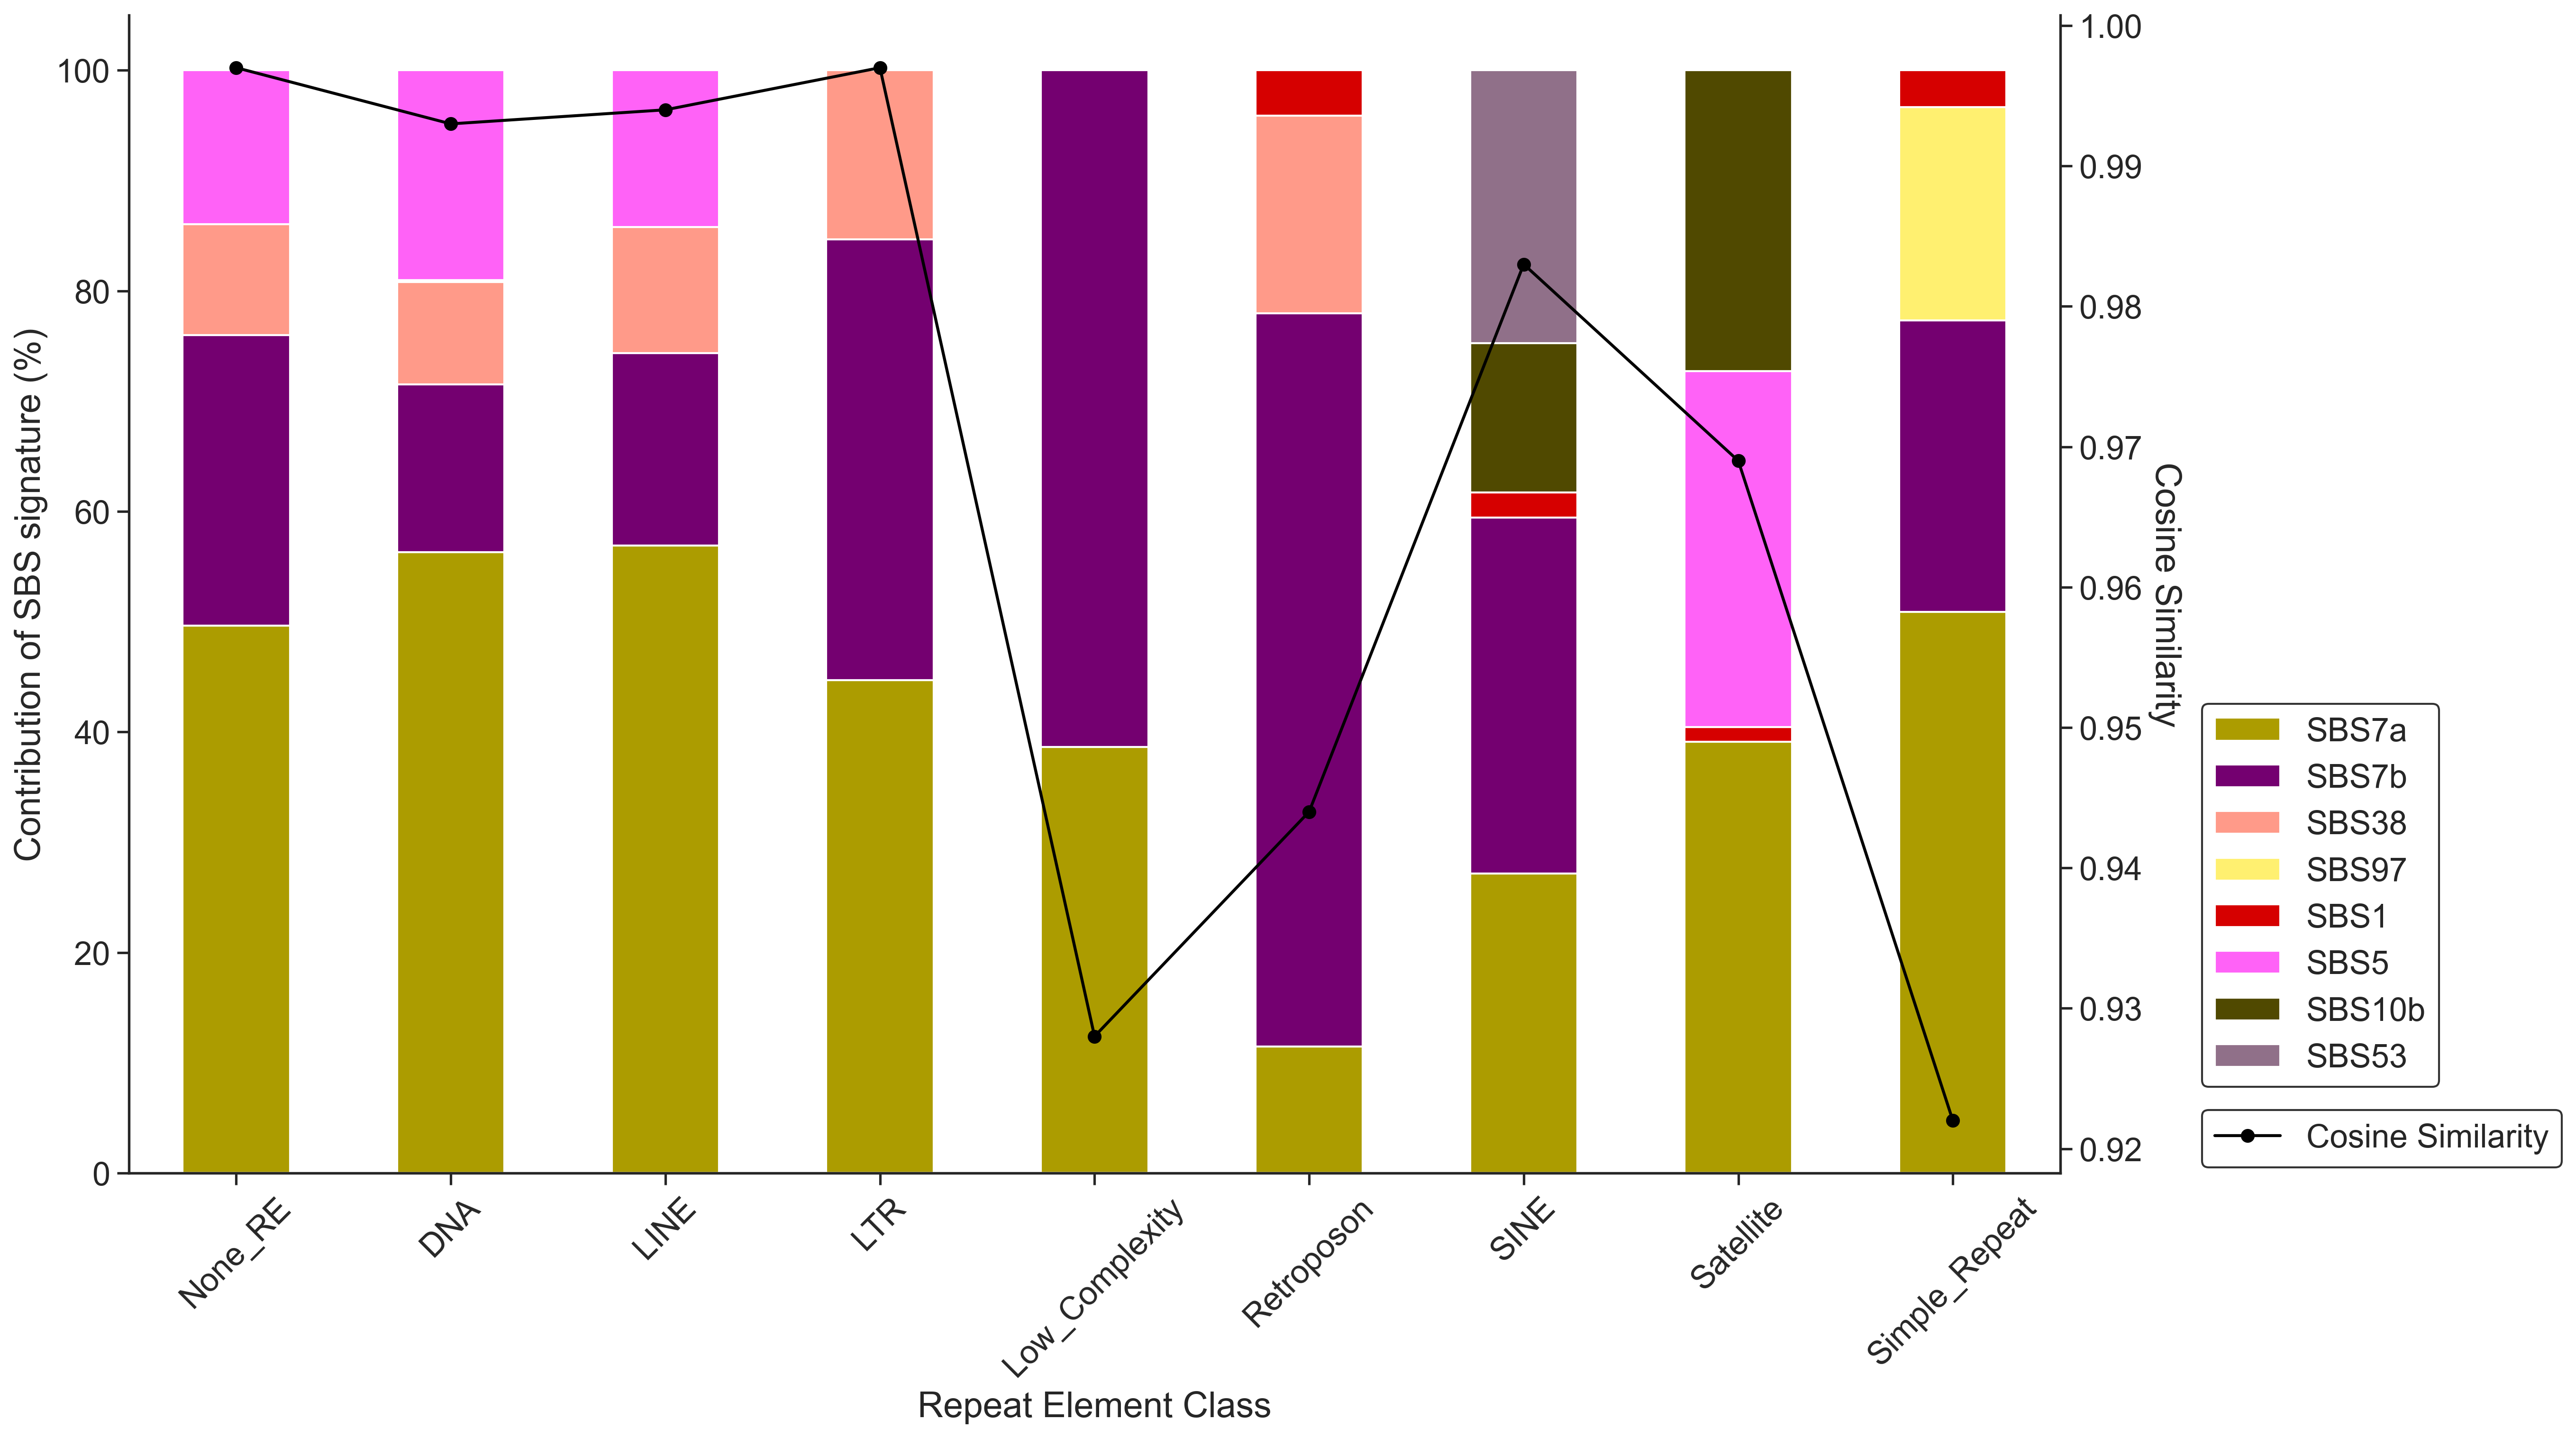

In [125]:
sns.set_theme(font="Arial", font_scale=1.5, style='ticks')
plt.rc("axes.spines", top=False, right=True)

fig, ax1 = plt.subplots(1,1, figsize=(18,10), constrained_layout=True)
df_percentage.reindex(df_percentage_order)[df_percentage_sbs_order].plot(kind='bar', stacked=True, legend=None, color=dict(zip(df_percentage.columns, sns.color_palette(cc.glasbey_warm, n_colors=len(df_percentage.columns)))), ax=ax1)
ax1.set_xlabel("Repeat Element Class")
ax1.set_ylabel("Contribution of SBS signature (%)")
ax1.legend(frameon=True, edgecolor='black', loc='center left', bbox_to_anchor=(1.065, 0.24))
ax1.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax2 = ax1.twinx()

df_cosine.reindex(df_percentage_order).reset_index().plot(x='RE', y='Cosine Similarity', kind='line', marker='o', color='black', ax=ax2, label='Cosine Similarity')

ax2.set_ylabel("Cosine Similarity", rotation=-90, labelpad=20)
ax2.legend(frameon=True, edgecolor='black', loc='center left', bbox_to_anchor=(1.065, 0.03))

sns.set_theme(font="Arial", font_scale=1.15, style='ticks')
plt.rc("axes.spines", top=False, right=False)

In [162]:
df = pd.read_csv("/mmfs1/gscratch/stergachislab/mhsohny/SMaHT/DSA/DSA_COLO829BL_v3.0.0.chrom.sizes", sep='\t', header=None)
df.columns = ['Contig', 'Length']
df = df.sort_values(ascending=False, by='Length')

df1 = df[df['Contig'].str.startswith('haplotype1-')].reset_index(drop=True).copy()
df2 = df[df['Contig'].str.startswith('haplotype2-')].reset_index(drop=True).copy()

df_re = pd.concat([df1, df2], axis=1)
df_re.columns = ['Contig_hap1', 'Length_hap1', 'Contig_hap2', 'Length_hap2']
df_re

Contig_hap1  Length_hap1         Contig_hap2  Length_hap2
0   haplotype1-0000012  249081600.0  haplotype2-0000059    248314242
1   haplotype1-0000011  200088031.0  haplotype2-0000058    201942482
2   haplotype1-0000013  191281738.0  haplotype2-0000060    191282352
3   haplotype1-0000010  182752966.0  haplotype2-0000057    184986789
4   haplotype1-0000026  172192213.0  haplotype2-0000079    171830684
5   haplotype1-0000009  160389005.0  haplotype2-0000056    159618310
6   haplotype1-0000027  155571023.0  haplotype2-0000051    145640671
7   haplotype1-0000024  147715744.0  haplotype2-0000052    135328831
8   haplotype1-0000003  146995301.0  haplotype2-0000064    134927773
9   haplotype1-0000004  135171367.0  haplotype2-0000072    133723320
10  haplotype1-0000017  134459179.0  haplotype2-0000074    130146602
11  haplotype1-0000021  133810748.0  haplotype2-0000077    111689197
12  haplotype1-0000002   99861314.0  haplotype2-0000050    110561407
13  haplotype1-0000018   96804152.0  haplotype2-0000070    101210174
14  haplotype1-0000001   95168741.0  haplotype2-0000048     84351089
15  haplotype1-0000019   94539174.0  haplotype2-0000073     81493628
16  haplotype1-0000014   81832500.0  haplotype2-0000075     76180628
17  haplotype1-0000015   79747619.0  haplotype2-0000055     74965859
18  haplotype1-0000008   76735356.0  haplotype2-0000068     74072654
19  haplotype1-0000022   75167552.0  haplotype2-0000053     61669246
20  haplotype1-0000006   61914015.0  haplotype2-0000061     50042149
21  haplotype1-0000028   51716906.0  haplotype2-0000065     44896236
22  haplotype1-0000005   44334624.0  haplotype2-0000054     40139062
23  haplotype1-0000023   42817876.0  haplotype2-0000076     37500019
24  haplotype1-0000007   40118900.0  haplotype2-0000080     26832284
25  haplotype1-0000025   25183810.0  haplotype2-0000078     25180758
26  haplotype1-0000016   18403401.0  haplotype2-0000049     24919458
27  haplotype1-0000020    5090593.0  haplotype2-0000062     24509933
28  haplotype1-0000031     692390.0  haplotype2-0000066     15369079
29  haplotype1-0000036     347556.0  haplotype2-0000071      4517556
30  haplotype1-0000037     233706.0  haplotype2-0000047      3427016
31  haplotype1-0000030     225371.0  haplotype2-0000069      2703105
32  haplotype1-0000029     170015.0  haplotype2-0000063      2105004
33  haplotype1-0000040      83049.0  haplotype2-0000046      1963971
34  haplotype1-0000041      77084.0  haplotype2-0000067      1323115
35  haplotype1-0000045      47848.0  haplotype2-0000137       647431
36  haplotype1-0000044      39839.0  haplotype2-0000128       350570
37  haplotype1-0000043      35012.0  haplotype2-0000134       286804
38  haplotype1-0000034      33984.0  haplotype2-0000136       273789
39  haplotype1-0000042      33542.0  haplotype2-0000194        58895
40  haplotype1-0000032      29213.0  haplotype2-0000189        51305
41  haplotype1-0000039      23508.0  haplotype2-0000195        44735
42  haplotype1-0000033      22035.0  haplotype2-0000115        41244
43  haplotype1-0000038      19476.0  haplotype2-0000127        31564
44  haplotype1-0000035      16314.0  haplotype2-0000118        31192
45                 NaN          NaN  haplotype2-0000190        22284

Text(45, 180000000, 'N50')

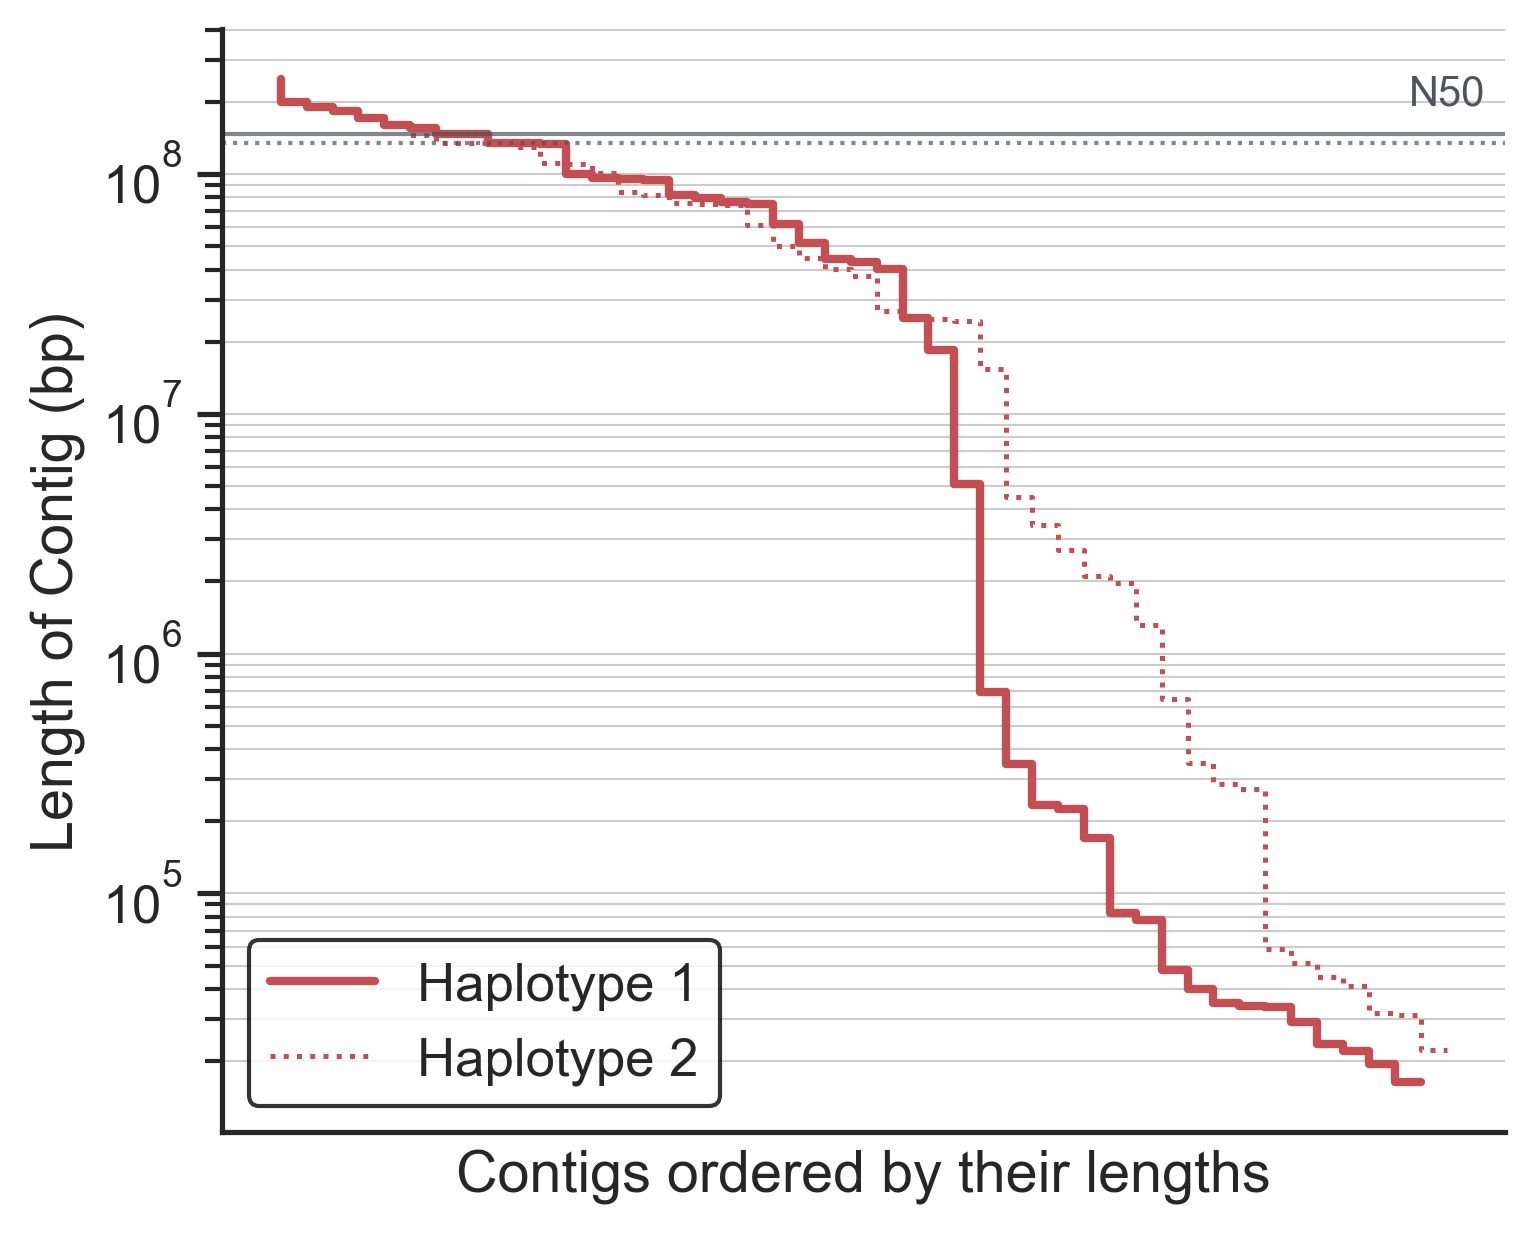

In [202]:
fig, ax = plt.subplots(1,1, figsize=(5,4), constrained_layout=True)
ax.step(df_re.index, df_re['Length_hap1'], linestyle='solid', color='r', linewidth=2, label='Haplotype 1')
ax.step(df_re.index, df_re['Length_hap2'], linestyle='dotted', color='r', linewidth=1.2, label='Haplotype 2')
ax.set_yscale('log')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel('Contigs ordered by their lengths')
ax.set_ylabel('Length of Contig (bp)')
ax.legend()
ax.legend(frameon=True, edgecolor='black')
ax.grid(visible=None, which='both', axis='both', linestyle='-', linewidth=0.5)

ax.axhline(y=146995301, color='#4E545C', linestyle='solid', linewidth=1, alpha=0.7) 
ax.axhline(y=134927773, color='#4E545C', linestyle='dotted', linewidth=1, alpha=0.7)

ax.text(45, 180000000, 'N50', va='bottom', ha='center', color='#4E545C', fontsize=10)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(8,4), constrained_layout=True)
ax.step(df1['Contig'], df1['Length'], linestyle='solid', color='r', linewidth=2)
ax.step(df2['Contig'], df2['Length'], linestyle='dotted', color='r', linewidth=1)
ax.set_yscale('log')
ax.set_xticks([])
ax.set_xticklabels([])
ax.set_xlabel('Contigs ordered by their lengths')
ax.set_ylabel('Length of Contig')